In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle
import corner
from scipy import integrate, interpolate
import emcee

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/Astro/Code/PG1522+101/science.mplstyle')

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/cloudy_grids/'

In [4]:
savedir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z=1.04430762/cloudy_fits/'

## Load TDP and PIE grids

### PIE

Obtain the UVB grid from FG20

In [5]:
fg20_z_grid, fg20_wav_grid, fg20_J_nu_grid = read_uvb('', 'fg20_galaxy.ascii')

Fetch the SED at $z=1$

In [6]:
z_test = 1

In [7]:
fg20_J_nu_test = fetch_sed(z_test, fg20_z_grid, fg20_J_nu_grid)

Specify $N_{\mathrm{HI}}$ grid points and get corresponding filenames

In [8]:
logN_HI_min = 12
logN_HI_max = 17
logN_HI_step = 0.25

logN_HI_arr = np.arange(logN_HI_min, logN_HI_max+logN_HI_step, logN_HI_step)

In [9]:
file_list = create_grid_file_list(logN_HI_arr)

Specify grid points for densities and metallicities

In [10]:
log_hdens_min = -5
log_hdens_max = 1
log_hdens_step = 0.25

log_hdens_arr = np.arange(log_hdens_min, log_hdens_max+log_hdens_step, log_hdens_step)
logU_arr = np.log10(calc_U(fg20_wav_grid, fg20_J_nu_test, 10**log_hdens_arr))

In [11]:
log_metals_min = -3
log_metals_max = 1
log_metals_step = 0.25

log_metals_arr = np.arange(log_metals_min, log_metals_max+log_metals_step, log_metals_step)

Load the final grid

In [12]:
pkl_file = open(rootdir+'final_grid.pkl', 'rb')
species_logN_samples = pickle.load(pkl_file)
pkl_file.close()

Interpolate this grid

In [13]:
species_logN_interp = {}

for s in list(species_logN_samples.keys()):
    
    species_logN_samples[s][species_logN_samples[s]==-np.inf] = -99
    
    species_logN_interp[s] = RegularGridInterpolator((logN_HI_arr, log_hdens_arr, log_metals_arr), 
                                                     species_logN_samples[s])

### TDP

Species names

In [14]:
ion_list = ['HI', 'HeI', 'CII', 'CIII', 'CIV', 'NII', 'NIII', 'NIV', 'NV',
            'OII', 'OIII', 'OIV', 'OV', 'OVI', 'SiII', 'SiIII', 'SiIV',
            'MgII', 'MgX', 'NeV', 'NeVI', 'NeVIII', 'SIV', 'SV', 'SVI']

Specify density/metallicity grid

In [15]:
log_metals_arr = [-2.6,-2.4,-2.2,-2.0,-1.8,-1.6,-1.4,-1.2,-1.0 ,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0]
log_hdens_arr = [-5.0,-4.8,-4.4,-4.2,-4.0,-3.8,-3.6,-3.4,-3.2,-3.0,-2.8,-2.6,-2.4,-2.2,-2.0,-1.8,-1.6]
logT_arr = np.arange(4.00, 6.01, 0.01)

Load grids

In [16]:
pkl_file = open(rootdir+'TDP_grid.pkl', 'rb')
logX_dict_TDP_samples = pickle.load(pkl_file)
pkl_file.close()

Set up the 3D grid across metallicity, density, and temperature

In [17]:
logX_dict_TDP_interp = {}

for ion in ion_list:
    logX_dict_TDP_interp[ion] = RegularGridInterpolator((log_metals_arr, log_hdens_arr, logT_arr), 
                                                     logX_dict_TDP_samples[ion])

# c1

## Fit high-density phase

### CIV, OIII, OIV diagnostic

In [18]:
logN_dict = {#'HI':'14.9, -0.1, +0.2',
            #'HeI':'13.2, -0.1, +0.1',
            #'CII':'<13.8',
            'CIII':'14.0, -0.5, +0.6',
            'CIV':'13.64, -0.04, +0.04',
            #'NIV':'13.01, -0.09, +0.09',
            #'NV':'<13.3',
            'OIII':'14.4, -0.1, +0.1',
            'OIV':'14.5, -0.1, +0.1',
            'OV':'13.97, -0.03, +0.03',
            #'OVI':'13.7, -0.2, +0.2',
            #'NeV':'<14.0',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.6',}
            #'SIV':'<14.6',
            #'SVI':'<13.3',
            #'FeII':'<11.6',}

In [20]:
gen_logN_ratio_str(logN_dict['CIV'], logN_dict['OIV'])

'-0.86, -0.11, 0.11'

In [61]:
logN_ratio_dict = {'OIV/OIII': '0.10, -0.14, 0.14',
                   'CIV/OIV': '-0.86, -0.11, 0.11',
                  }

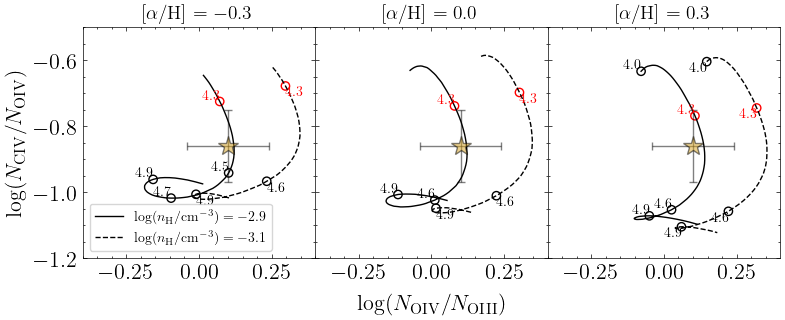

In [62]:
fig, axes = plt.subplots(1,3,figsize=(3*3,3), sharex=True, sharey=True)

ion1 = 'OIII'
ion2 = 'OIV'
ion3 = 'OIV'
ion4 = 'CIV'

# Plot measurements

scat_logN_ratio(axes[0], '{}/{}'.format(ion2, ion1), '{}/{}'.format(ion4, ion3), logN_ratio_dict)
axes[0].set_title(r'$\mathrm{[\alpha/H]}=-0.3$', fontsize=14)

scat_logN_ratio(axes[1], '{}/{}'.format(ion2, ion1), '{}/{}'.format(ion4, ion3), logN_ratio_dict)
axes[1].set_title(r'$\mathrm{[\alpha/H]}=0.0$', fontsize=14)

scat_logN_ratio(axes[2], '{}/{}'.format(ion2, ion1), '{}/{}'.format(ion4, ion3), logN_ratio_dict)
axes[2].set_title(r'$\mathrm{[\alpha/H]}=0.3$', fontsize=14)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'$\log(N_\mathrm{OIV}/N_\mathrm{OIII})$', labelpad=25)
ax_label.set_ylabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{OIV})$', labelpad=40)

plt.subplots_adjust(wspace=0, hspace=0.0)

# Plot tracks
# Metallicities and densities
m1 = -0.3
m2 = 0.0
m3 = 0.3

d1 = -2.9
d2 = -3.1
d3 = -2.7

# Temperature range
T_plot_min = 4.0
T_plot_max = 5.0
dT_plot = 0.01

T_mark_min = 4.0
T_mark_max = 5.0
dT_mark = 0.3

# Line width temperature
T_special = 4.3

# Plot range
x_min = -0.4
x_max = 0.4

y_min = -1.2
y_max = -0.5

# Linestyles 
l1 = '-'
l2 = '--'
l3 = ':'

plot_logN_ratio_track(axes[0], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m1, d1, 
                      T_plot_min, T_plot_max, dT_plot,
                      4.3, 5.0, 0.2,
                      x_min, x_max, y_min, y_max,
                      l1, 'right', 'bottom', T_special)


plot_logN_ratio_track(axes[0], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m1, d2, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l2, 'left', 'top', T_special)

#plot_logN_ratio_track(axes[0], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
#                      m1, d3, 
#                      T_plot_min, T_plot_max, dT_plot,
#                      T_mark_min, T_mark_max, dT_mark,
#                      x_min, x_max, y_min, y_max,
#                      l3, 'left', 'top')

axes[0].legend(fontsize=10)

# metals = -0.3

plot_logN_ratio_track(axes[1], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m2, d1, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l1, 'right', 'bottom', T_special)

plot_logN_ratio_track(axes[1], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m2, d2, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l2, 'left', 'top', T_special)

#plot_logN_ratio_track(axes[1], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
#                      m2, d3, 
#                      T_plot_min, T_plot_max, dT_plot,
#                      T_mark_min, T_mark_max, dT_mark,
#                      x_min, x_max, y_min, y_max,
#                      l3, 'left', 'top')

# metals = 0.0

plot_logN_ratio_track(axes[2], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m3, d1, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l1, 'right', 'bottom', T_special)

plot_logN_ratio_track(axes[2], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m3, d2, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l2, 'right', 'top', T_special)

#plot_logN_ratio_track(axes[2], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
#                      m3, d3, 
#                      T_plot_min, T_plot_max, dT_plot,
#                      T_mark_min, T_mark_max, dT_mark,
#                      x_min, x_max, y_min, y_max,
#                      l3, 'left', 'top')

plt.savefig(savedir+'z_104_c1H_diagnostic.pdf', dpi=300)
plt.savefig(savedir+'z_104_c1H_diagnostic.png', dpi=300)

### High-density phase (TDP fit - fixed temperature)

In [63]:
def log_prior(log_metals, log_hdens, C_O, N_O):
    
    if log_metals_arr[0]<log_metals<log_metals_arr[-1] and -3<log_metals+C_O<1 and -3<log_metals+N_O<1: #[C/H]
        if log_hdens_arr[0]<log_hdens<log_hdens_arr[-1]:
            return 0.
        else:
            return -np.inf
    else:
        return -np.inf

In [64]:
def log_likelihood(log_metals, log_hdens, C_O, N_O, logN_dict, logX_dict_TDP_interp):
    
    logN_HI_obs = logN_HI_test # Measured N(HI) to generate column densities
    
    ll = 0
    
    for ion in list(logN_dict.keys()):
        
        # Model side: prediction adjusted for elemental abundance
        elem = ion_species_dict[ion].split('+')[0]
        
        y_bar = predict_col_dens_TDP(ion, log_metals, log_hdens, logT_test, logN_HI_obs, logX_dict_TDP_interp)
        if elem == 'C':
            y_bar += C_O 
        if elem == 'N':
            y_bar += N_O
            
        # Data side: handle upper limits, lower limits, and measurements separately
        logN_str = logN_dict[ion]
        
        ll += compute_ll(logN_str, y_bar)

    return ll

In [65]:
def log_probability(params, logN_dict, logX_dict_TDP_interp):
    
    log_metals, log_hdens, C_O, N_O = params
    
    lp = log_prior(log_metals,log_hdens,C_O,N_O)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp+log_likelihood(log_metals,log_hdens,C_O,N_O,logN_dict,logX_dict_TDP_interp)

In [66]:
logN_dict = {#'HI':'14.9, -0.1, +0.2',
            #'HeI':'13.2, -0.1, +0.1',
            'CII':'<13.8',
            'CIII':'14.0, -0.5, +0.6',
            'CIV':'13.64, -0.04, +0.04',
            'NIV':'13.01, -0.09, +0.09',
            #'NV':'<13.3',
            'OIII':'14.4, -0.1, +0.1',
            'OIV':'14.5, -0.1, +0.1',
            #'OV':'13.97, -0.03, +0.03',
            #'OVI':'13.7, -0.2, +0.2',
            #'NeV':'<14.0',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',}
            #'SVI':'<13.3',
            #'FeII':'<11.6',}

In [69]:
log_metals_test = 0.0
log_hdens_test = -2.9
logT_test = 4.3
logN_HI_test = 14.9
C_O_test = -0.1
N_O_test = -0.6

logN_test = predict_col_dens_model_TDP(logN_dict,log_metals_test,log_hdens_test,logT_test,logN_HI_test,logX_dict_TDP_interp, C_O_test, N_O_test)

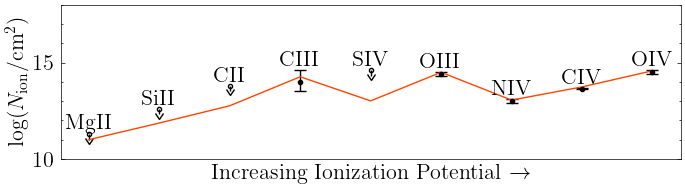

In [70]:
fig, ax = plt.subplots(1, figsize=(8,2))

plot_column_densities_obs(logN_dict, fig, ax)

ax.plot(np.arange(len(logN_dict)), logN_test, color='orangered')

In [71]:
pos = np.array([log_metals_test, log_hdens_test, C_O_test, N_O_test]) + 1e-4 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape

In [72]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, logX_dict_TDP_interp)
)

In [73]:
sampler.run_mcmc(pos, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [02:51<00:00,  2.92it/s]


In [74]:
flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_metals', 'log_hdens', 'C_O', 'N_O'])
flat_samples.to_csv(savedir+'TDP_hi_dens_c1_fixT.csv', index=False)

#flat_samples = pd.read_csv(savedir+'TDP_hi_dens_c1_fixT.csv')

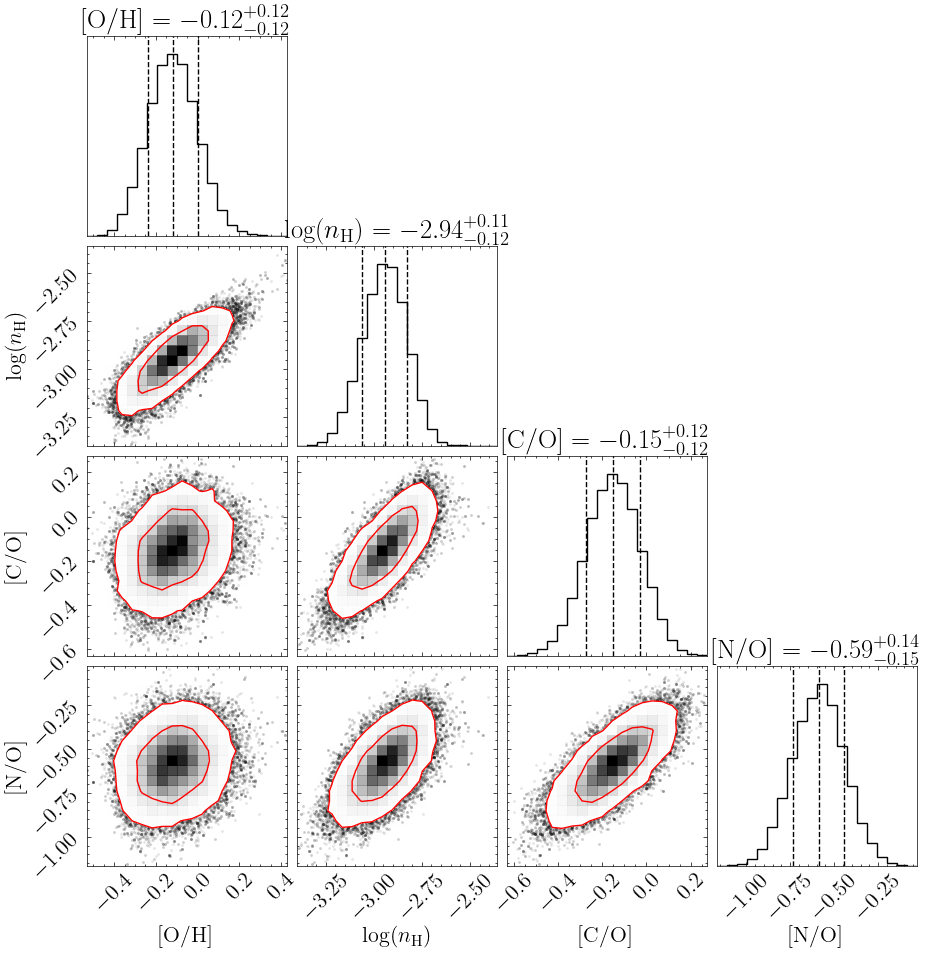

In [75]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\mathrm{[O/H]}$', r'$\log(n_\mathrm{H})$', r'$\mathrm{[C/O]}$',r'$\mathrm{[N/O]}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [78]:
np.median(flat_samples['C_O'])

-0.1496810973834259

In [79]:
np.median(flat_samples['N_O'])-np.percentile(flat_samples['N_O'], 100*(1-cdf_1sig))

0.15025837022050736

Make a plot

In [81]:
logN_dict = {#'HI':'14.9, -0.1, +0.2',
            'HeI':'13.2, -0.1, +0.1',
            'CII':'<13.8',
            'CIII':'14.0, -0.5, +0.6',
            'CIV':'13.64, -0.04, +0.04',
            'NIV':'13.01, -0.09, +0.09',
            #'NV':'<13.3',
            'OIII':'14.4, -0.1, +0.1',
            'OIV':'14.5, -0.1, +0.1',
            'OV':'13.97, -0.03, +0.03',
            'OVI':'13.7, -0.2, +0.2',
            #'NeV':'<14.0',
            #'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',}
            #'SVI':'<13.3',
            #'FeII':'<11.6',}

In [82]:
b_dict = {'HI':'18, -2, +1',
          'HeI': '9.7, -0.8, +0.8',
          'CIII':'6.4, -0.4, +0.4',
          'CIV':'6.4, -0.4, +0.4',
          'NIV':'6.4, -0.4, +0.4',
          'OIII':'6.4, -0.4, +0.4',
          'OIV':'6.4, -0.4, +0.4',
          'OV':'23, -1, +1',
          'OVI':'23, -1, +1'}

In [83]:
logN_species_best = predict_col_dens_model_TDP(logN_dict,
                                               np.median(flat_samples['log_metals']),
                                               np.median(flat_samples['log_hdens']),
                                               logT_test,
                                               logN_HI_test,
                                               logX_dict_TDP_interp,
                                               np.median(flat_samples['C_O']),
                                               np.median(flat_samples['N_O']))

In [84]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [85]:
logN_res_up = {k:'<0.8' for k in list(logN_res_dict.keys())}

#logN_res_up['SiIII'] = '<0.4'
#logN_res_up['SiIV'] = '<0.4'
#logN_res_up['OIII'] = '<0.4'
#logN_res_up['NIV'] = '<0.4'

In [86]:
logN_species_grid = np.zeros((len(logN_dict), len(flat_samples)))

ctr = 0

for i in range(len(ion_species_dict)):
    
    ion = list(ion_species_dict.keys())[i]
    
    if ion in list(logN_dict.keys()):
        s = ion_species_dict[ion] # Species, for PIE
        elem = ion_species_dict[ion].split('+')[0] # Element, for non-solar abundances
        
        logN_species_grid[ctr,:] = predict_col_dens_TDP(ion, 
                                      flat_samples['log_metals'],
                                      flat_samples['log_hdens'],
                                      logT_test,
                                      logN_HI_test,
                                      logX_dict_TDP_interp)
        
        if elem == 'C':
            logN_species_grid[ctr,:] += flat_samples['C_O']
            
        if elem == 'N':
            logN_species_grid[ctr,:] += flat_samples['N_O']
            
        ctr += 1

In [87]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

C_O_lo = np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))
C_O_hi = np.percentile(flat_samples['C_O'], 100*cdf_1sig)

N_O_lo = np.percentile(flat_samples['N_O'], 100*(1-cdf_1sig))
N_O_hi = np.percentile(flat_samples['N_O'], 100*cdf_1sig)

for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    C_O = flat_samples['C_O'][i]
    N_O = flat_samples['N_O'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and C_O_lo<C_O<C_O_hi and N_O_lo<N_O<N_O_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

In [88]:
import matplotlib.lines as mlines

In [89]:
z_sys = 1.04430762

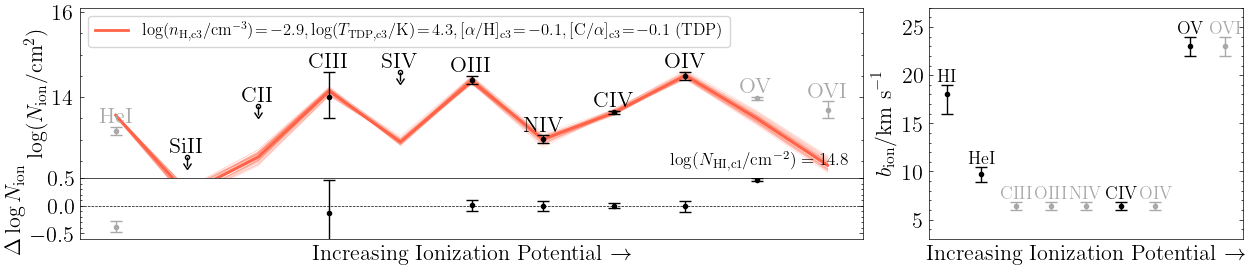

In [91]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'],
                          gray_out = ['HeI','OV','OVI',
                                     'NeV', 'NeVI'], dy=.15)

axd['upper left'].set_ylim(12.1,16.1)

axd['upper left'].text(len(logN_dict)-0.7, 12.4, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.8$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H,c3}/\mathrm{cm}^{-3}) \!=\! -2.9, \log(T_\mathrm{TDP,c3}/\mathrm{K})\!=\!4.3, \mathrm{[\alpha/H]_{c3}} \!=\! -0.1, \mathrm{[C/\alpha]_{c3}}\!=\!-0.1$ (TDP)'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'],gray_out = ['HeI','OVI','NeV', 'NeVI'],label_ions=False,dy=.1)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'],gray_out = ['HeI','OVI','NeV', 'NeVI'],label_ions=False,dy=.1)

axd['lower left'].set_ylim(-0.6,.5)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=13, gray_out = ['CIII', 'OIII', 'OIV', 'NIV', 'OVI'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(3,27)
#ax.set_title('Two-phase decomposition for a CIV absorber', fontsize=18)

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_TDP.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)
plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_TDP.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Cloud size posterior

In [92]:
logl = get_logl_TDP(flat_samples['log_metals'], flat_samples['log_hdens'], logT_test, logN_HI_test, logX_dict_TDP_interp)

(array([7.1000e+01, 8.6800e+03, 5.1199e+04, 1.9526e+04, 4.8500e+02,
        1.7000e+01, 1.1000e+01, 9.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-1.46514005, -1.03453947, -0.60393889, -0.17333832,  0.25726226,
         0.68786284,  1.11846341,  1.54906399,  1.97966456,  2.41026514,
         2.84086572]),
 <BarContainer object of 10 artists>)

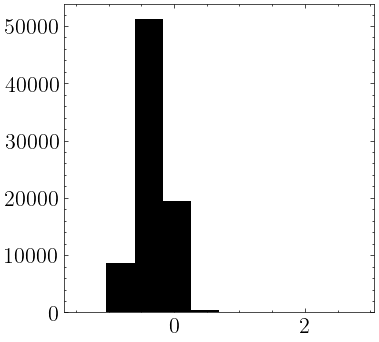

In [93]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logl)

In [94]:
get_quantiles(logl)

-0.33 -0.22 0.24


## Two-phase fit

### OIV, OV OVI diagnostic

In [273]:
logN_dict = {#'HI':'14.8, -0.1, +0.1',
            #'HeI':'13.2, -0.1, +0.1',
            #'CII':'<13.8',
            #'CIII':'14.0, -0.4, +0.5',
            #'CIV':'13.64, -0.02, +0.02',
            #'NIV':'13.02, -0.09, +0.09',
            #'NV':'<13.3',
            #'OIII':'14.33, -0.07, +0.07',
            'OIV':'14.46, -0.06, +0.06',
            'OV':'14.00, -0.02, +0.02',
            'OVI':'13.8, -0.1, +0.1',}
            #'NeV':'<14.0',
            #'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            #'SiII':'<12.6',
            #'SIV':'<14.6',
            #'SVI':'<13.3',
            #'FeII':'<11.6'}

In [274]:
gen_logN_ratio_str(logN_dict['OV'], logN_dict['OIV'])

'-0.46, -0.06, 0.06'

In [275]:
logN_ratio_dict = {'OV/OIV': '-0.46, -0.06, 0.06',
                   'OVI/OV': '-0.20, -0.10, 0.10',
                  }

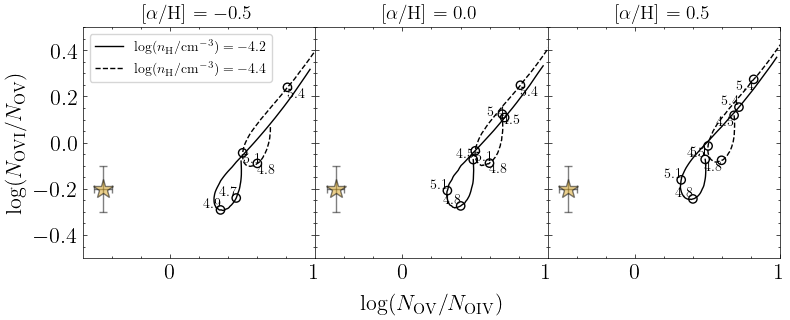

In [282]:
fig, axes = plt.subplots(1,3,figsize=(3*3,3), sharex=True, sharey=True)

ion1 = 'OIV'
ion2 = 'OV'
ion3 = 'OV'
ion4 = 'OVI'

# Plot measurements

scat_logN_ratio(axes[0], '{}/{}'.format(ion2, ion1), '{}/{}'.format(ion4, ion3), logN_ratio_dict)
axes[0].set_title(r'$\mathrm{[\alpha/H]}=-0.5$', fontsize=14)

scat_logN_ratio(axes[1], '{}/{}'.format(ion2, ion1), '{}/{}'.format(ion4, ion3), logN_ratio_dict)
axes[1].set_title(r'$\mathrm{[\alpha/H]}=0.0$', fontsize=14)

scat_logN_ratio(axes[2], '{}/{}'.format(ion2, ion1), '{}/{}'.format(ion4, ion3), logN_ratio_dict)
axes[2].set_title(r'$\mathrm{[\alpha/H]}=0.5$', fontsize=14)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'$\log(N_\mathrm{OV}/N_\mathrm{OIV})$', labelpad=25)
ax_label.set_ylabel(r'$\log(N_\mathrm{OVI}/N_\mathrm{OV})$', labelpad=40)

plt.subplots_adjust(wspace=0, hspace=0.0)

# Plot tracks
# Metallicities and densities
m1 = -0.5
m2 = 0.0
m3 = 0.5

d1 = -4.2
d2 = -4.4
d3 = -2.7

# Temperature range
T_plot_min = 4.5
T_plot_max = 5.5
dT_plot = 0.01

T_mark_min = 4.5
T_mark_max = 5.5
dT_mark = 0.3

# Plot range
x_min = -0.6
x_max = 1.0

y_min = -0.5
y_max = 0.5

# Linestyles 
l1 = '-'
l2 = '--'
l3 = ':'

plot_logN_ratio_track(axes[0], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m1, d1, 
                      T_plot_min, T_plot_max, dT_plot,
                      4.3, 5.0, 0.2,
                      x_min, x_max, y_min, y_max,
                      l1, 'right', 'bottom')


plot_logN_ratio_track(axes[0], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m1, d2, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l2, 'left', 'top')

#plot_logN_ratio_track(axes[0], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
#                      m1, d3, 
#                      T_plot_min, T_plot_max, dT_plot,
#                      T_mark_min, T_mark_max, dT_mark,
#                      x_min, x_max, y_min, y_max,
#                      l3, 'left', 'top')

axes[0].legend(fontsize=10)

# metals = -0.3

plot_logN_ratio_track(axes[1], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m2, d1, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l1, 'right', 'bottom')

plot_logN_ratio_track(axes[1], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m2, d2, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l2, 'left', 'top')

#plot_logN_ratio_track(axes[1], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
#                      m2, d3, 
#                      T_plot_min, T_plot_max, dT_plot,
#                      T_mark_min, T_mark_max, dT_mark,
#                      x_min, x_max, y_min, y_max,
#                      l3, 'left', 'top')

# metals = 0.0

plot_logN_ratio_track(axes[2], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m3, d1, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l1, 'right', 'bottom')

plot_logN_ratio_track(axes[2], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m3, d2, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l2, 'right', 'top')

#plot_logN_ratio_track(axes[2], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
#                      m3, d3, 
#                      T_plot_min, T_plot_max, dT_plot,
#                      T_mark_min, T_mark_max, dT_mark,
#                      x_min, x_max, y_min, y_max,
#                      l3, 'left', 'top')

#plt.savefig(savedir+'z_104_c1H_diagnostic.pdf', dpi=300)
#plt.savefig(savedir+'z_104_c1H_diagnostic.png', dpi=300)

### TDP + TDP fit

In [283]:
def log_prior_mix_TDP(log_metals_p1, log_hdens_p1, logT_p1, C_O_p1, N_O_p1,
                log_metals_p2, log_hdens_p2, logT_p2, C_O_p2, N_O_p2, logN_HI_p2, logX_dict_TDP_interp):
        
    logN_HI_obs = logN_HI_test
    
    if log_metals_arr[0]<log_metals_p1<log_metals_arr[-1] and log_metals_arr[0]<log_metals_p2<log_metals_arr[-1]:
        if -3<log_metals_p1+C_O_p1<1 and -3<log_metals_p2+C_O_p2<1 and -3<log_metals_p1+N_O_p1<1 and -3<log_metals_p2+N_O_p2<1:
            if log_hdens_arr[0]<log_hdens_p1<-2.3 and log_hdens_arr[0]<log_hdens_p2<log_hdens_arr[-1]:
                if logT_p1>4.0 and 4.0<logT_p2<5.8: #
                    if 12.0<logN_HI_p2<logN_HI_obs:
                        if log_hdens_p1>log_hdens_p2 and logT_p1<logT_p2: # CIV denser and colder
                            logl_p1 = get_logl_TDP(log_metals_p1, log_hdens_p1, logT_p1, logN_HI_obs, logX_dict_TDP_interp)
                            logl_p2 = get_logl_TDP(log_metals_p2, log_hdens_p2, logT_p2, logN_HI_p2, logX_dict_TDP_interp)

                            # Limits for cloud size
                            logl_p1_S = np.log10(0.03*(10**log_hdens_p1/1e-3)**-1) # in kpc
                            logl_p1_J = np.log10(40*(10**log_hdens_p1/1e-3)**-0.5*(10**logT_p1/1e4)**0.5) # added scaling for temperature                            
                            
                            logl_p2_S = np.log10(0.03*(10**log_hdens_p2/1e-3)**-1) # in kpc
                            logl_p2_J = np.log10(40*(10**log_hdens_p2/1e-3)**-0.5*(10**logT_p2/1e4)**0.5) # added scaling for temperature
                            
                            if logl_p1<logl_p2 and logl_p1_S<logl_p1<logl_p1_J and logl_p2_S<logl_p2<logl_p2_J:
                                return np.log(10**logN_HI_p2)
                            else:
                                return -np.inf
                        else:
                            return -np.inf
                    else:
                        return -np.inf
                else:
                    return -np.inf
            else:
                return -np.inf
        else:
            return -np.inf
    else:
        return -np.inf

In [284]:
def log_likelihood_mix_TDP(log_metals_p1, log_hdens_p1, logT_p1, C_O_p1, N_O_p1,
                     log_metals_p2, log_hdens_p2, logT_p2, C_O_p2, N_O_p2, logN_HI_p2,
                     logN_dict, logX_dict_TDP_interp):
    
    logN_HI_obs = logN_HI_test # Measured N(HI) to generate column densities
    
    ll = 0
    
    for ion in list(logN_dict.keys()):
        
        if ion == 'HI':
            # For HI there is nothing to bring from the grid
            y_bar_p1 = logN_HI_obs
            y_bar_p2 = logN_HI_p2
            
        else:
            # Model side: prediction adjusted for elemental abundance
            elem = ion_species_dict[ion].split('+')[0]

            y_bar_p1 = predict_col_dens_TDP(ion, log_metals_p1, log_hdens_p1, logT_p1, logN_HI_obs, logX_dict_TDP_interp)
            y_bar_p2 = predict_col_dens_TDP(ion, log_metals_p2, log_hdens_p2, logT_p2, logN_HI_p2, logX_dict_TDP_interp)

            if elem == 'C': 
                y_bar_p1 += C_O_p1
                y_bar_p2 += C_O_p2

            if elem == 'N':
                y_bar_p1 += N_O_p1
                y_bar_p2 += N_O_p2
          
        y_bar = np.log10(10**y_bar_p1 + 10**y_bar_p2)
            
        # Data side: handle upper limits, lower limits, and measurements separately
        logN_str = logN_dict[ion]
        
        ll += compute_ll(logN_str, y_bar)

    return ll

In [285]:
def log_probability_mix_TDP(params, logN_dict, logX_dict_TDP_interp):
    
    log_metals_p1,log_hdens_p1,logT_p1,C_O_p1,N_O_p1,log_metals_p2,log_hdens_p2,logT_p2,C_O_p2,N_O_p2,logN_HI_p2 = params
    
    lp = log_prior_mix_TDP(log_metals_p1,log_hdens_p1,logT_p1,C_O_p1,N_O_p1,log_metals_p2,log_hdens_p2,logT_p2,C_O_p2,N_O_p2,logN_HI_p2,logX_dict_TDP_interp)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp+log_likelihood_mix_TDP(log_metals_p1,log_hdens_p1,logT_p1,C_O_p1,N_O_p1,log_metals_p2,log_hdens_p2,logT_p2,C_O_p2,N_O_p2,logN_HI_p2,logN_dict,logX_dict_TDP_interp)

In [286]:
logN_dict = {'HI':'14.8, -0.1, +0.1',
            #'HeI':'13.2, -0.1, +0.1',
            'CII':'<13.8',
            'CIII':'14.0, -0.4, +0.5',
            'CIV':'13.64, -0.02, +0.02',
            'NIV':'13.02, -0.09, +0.09',
            'NV':'<13.3',
            'OIII':'14.33, -0.07, +0.07',
            'OIV':'14.46, -0.06, +0.06',
            'OV':'14.00, -0.02, +0.02',
            'OVI':'13.8, -0.1, +0.1',
            'NeV':'<14.0',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',
            'SVI':'<13.3',}
            #'FeII':'<11.6'}

In [287]:
log_metals_test_p1 = 0.0
log_hdens_test_p1 = -2.9
logT_test_p1 = 4.3
C_O_test_p1 = -0.2
N_O_test_p1 = -0.7
logN_HI_test = 14.8

logN_test_p1 = predict_col_dens_model_TDP(logN_dict,log_metals_test_p1,log_hdens_test_p1,logT_test_p1,logN_HI_test,logX_dict_TDP_interp,C_O_test_p1,N_O_test_p1)

log_metals_test_p2 = -0.5
log_hdens_test_p2 = -4.4
logT_test_p2 = 5.0
C_O_test_p2 = 0.6
N_O_test_p2 = 0.0
logN_HI_test_p2 = 13.0

logN_test_p2 = predict_col_dens_model_TDP(logN_dict,log_metals_test_p2,log_hdens_test_p2,logT_test_p2,logN_HI_test_p2,logX_dict_TDP_interp,C_O_test_p2,N_O_test_p2)

logN_test = np.log10(10**logN_test_p1 + 10**logN_test_p2)

(12.0, 15.0)

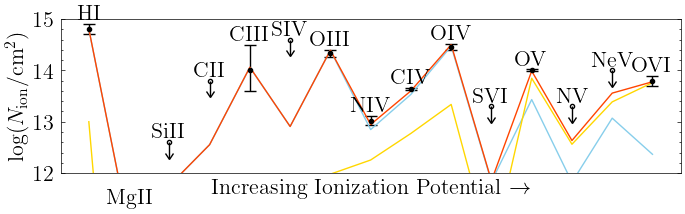

In [288]:
fig, ax = plt.subplots(1, figsize=(8,2))

plot_column_densities_obs(logN_dict, fig, ax)
ax.plot(np.arange(len(logN_dict)), logN_test_p1, color='skyblue')
ax.plot(np.arange(len(logN_dict)), logN_test_p2, color='gold')
ax.plot(np.arange(len(logN_dict)), logN_test, color='orangered')

ax.set_ylim(12.,15)

In [289]:
pos = np.array([log_metals_test_p1,log_hdens_test_p1,logT_test_p1,C_O_test_p1,N_O_test_p1, 
                log_metals_test_p2,log_hdens_test_p2,logT_test_p2,C_O_test_p2,N_O_test_p2,logN_HI_test_p2]) + 1e-4 * np.random.randn(200, 11)
nwalkers, ndim = pos.shape

In [290]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_mix_TDP, args=(logN_dict,logX_dict_TDP_interp)
)

In [291]:
#sampler.run_mcmc(pos, 1000, progress=True);

In [292]:
#flat_samples_mix = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_metals_p1','log_hdens_p1','logT_p1','C_O_p1','N_O_p1',
#                                         'log_metals_p2','log_hdens_p2','logT_p2','C_O_p2','N_O_p2','logN_HI_p2'])
#flat_samples_mix.to_csv(savedir+'TDP+TDP_c1.csv', index=False)

flat_samples_mix = pd.read_csv(savedir+'TDP+TDP_c1.csv')

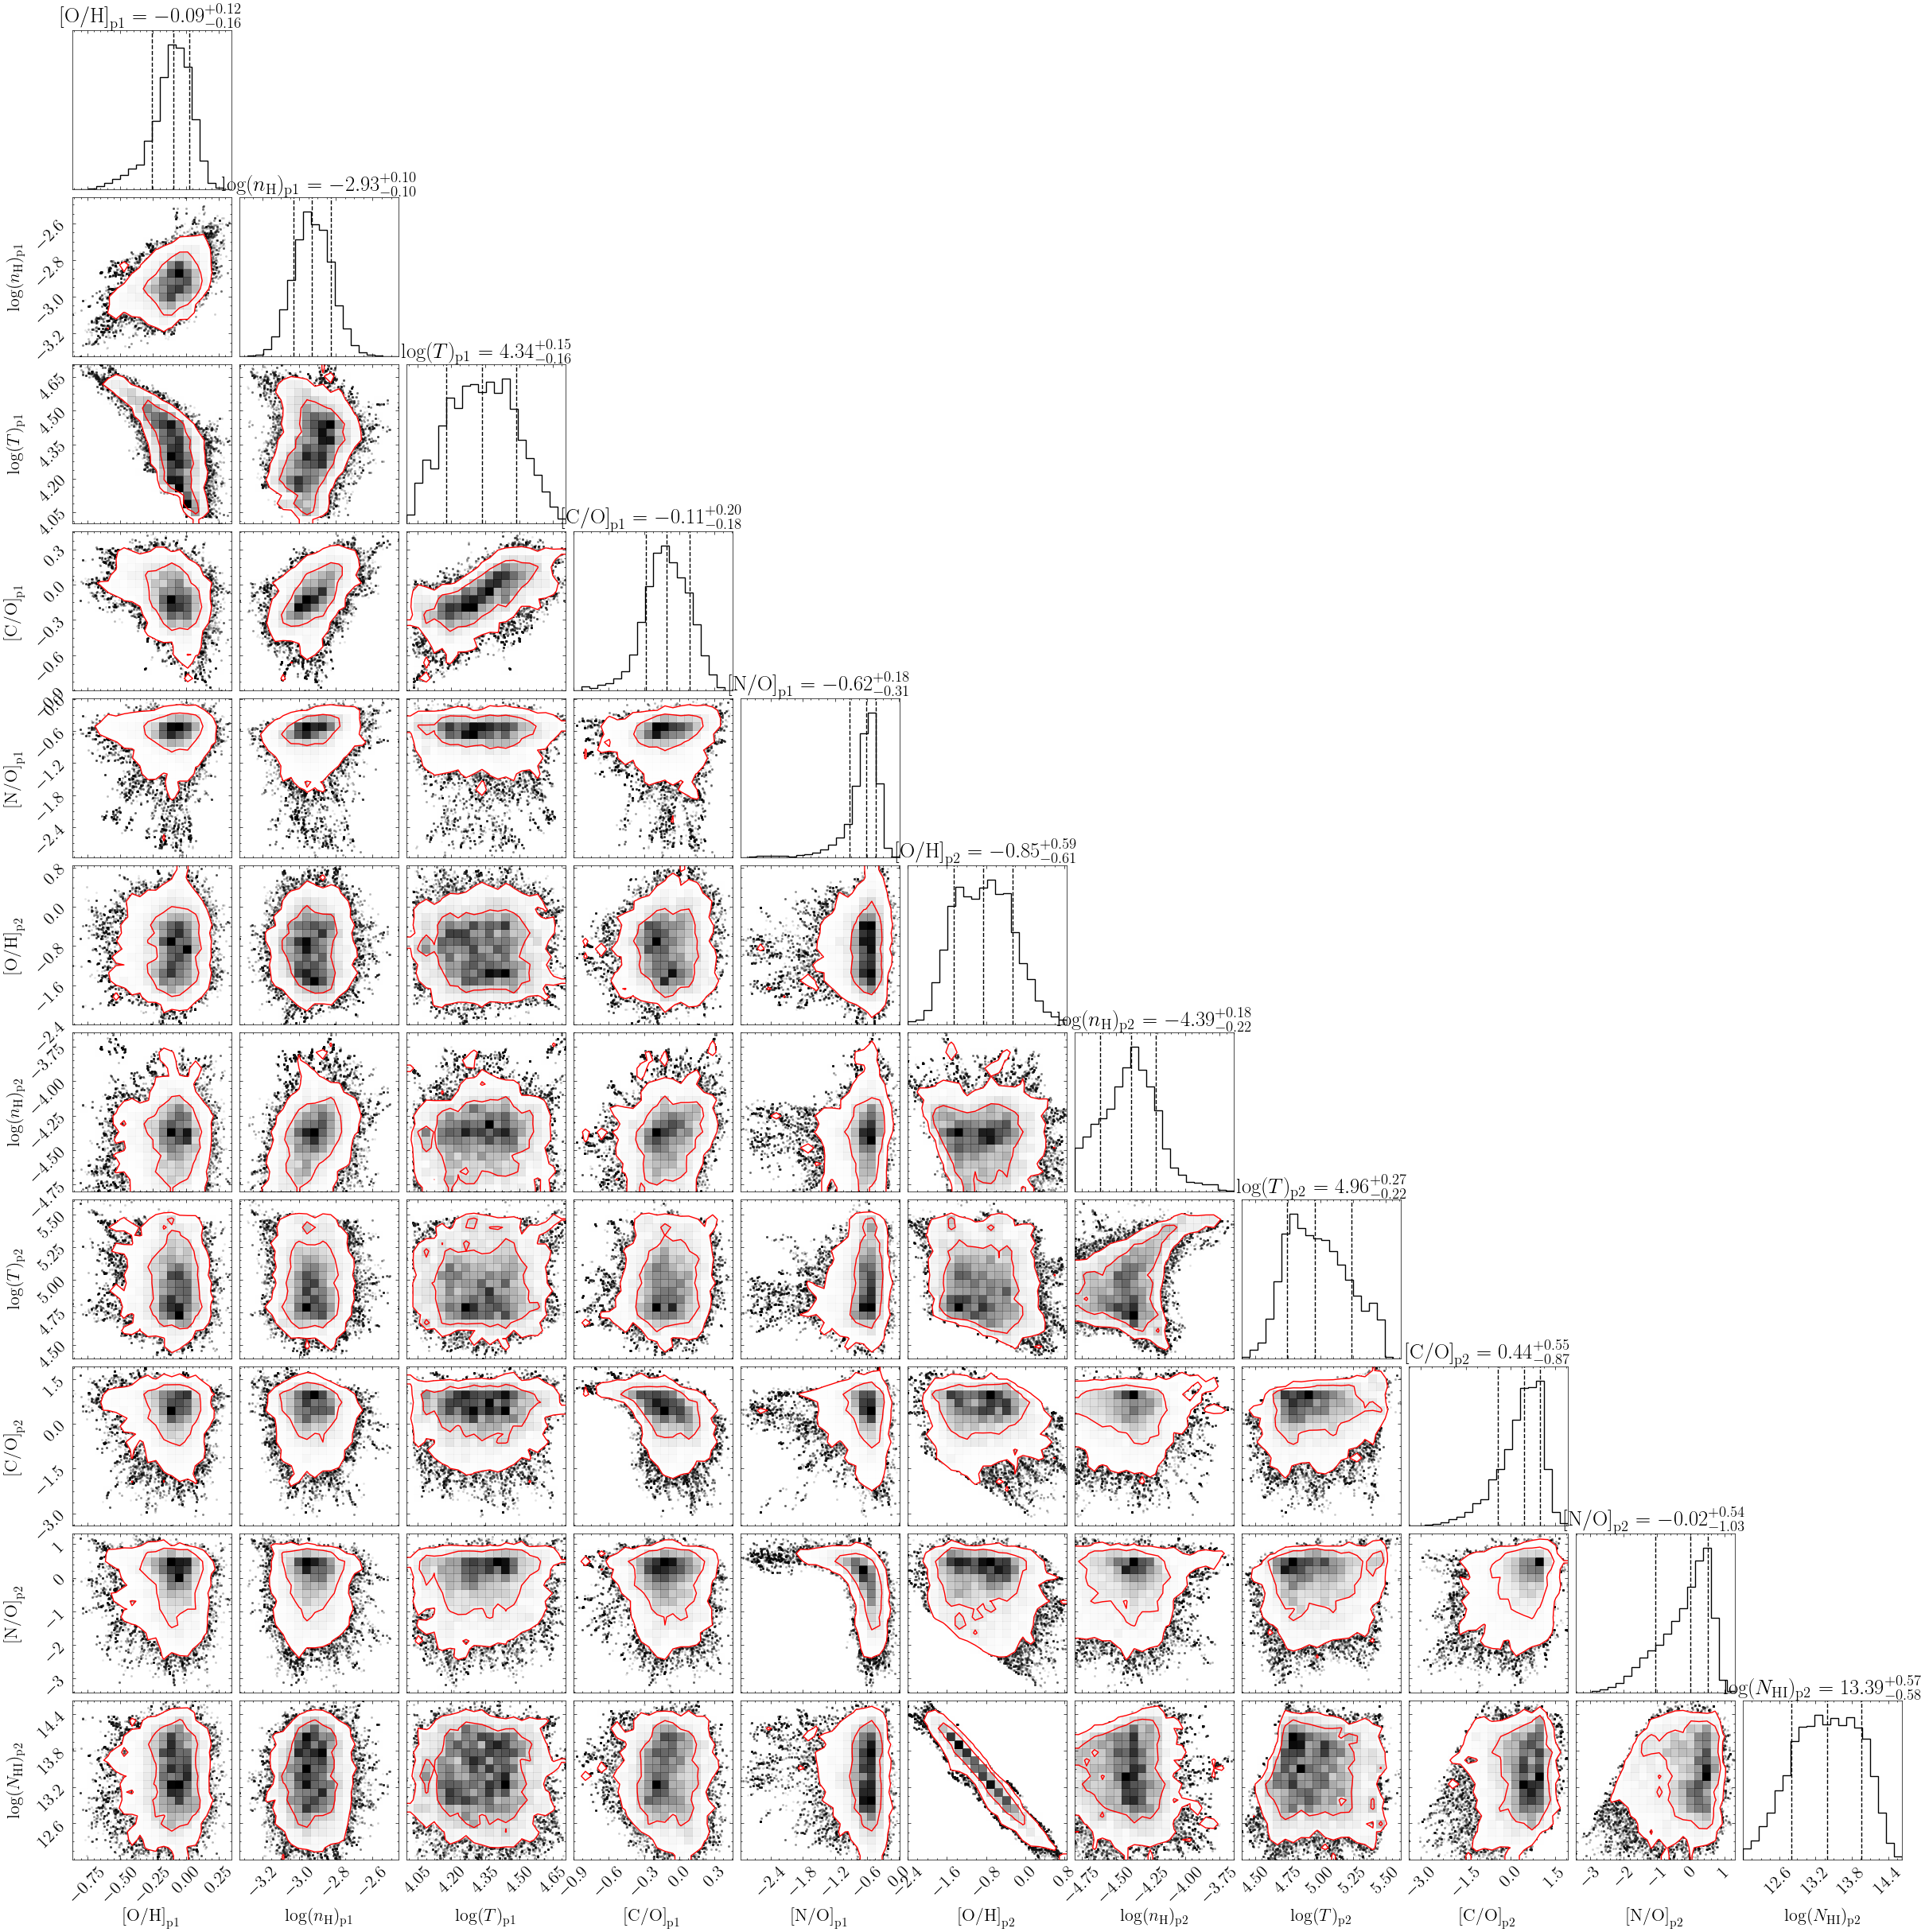

In [293]:
fig = corner.corner(
    flat_samples_mix, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\mathrm{[O/H]}_\mathrm{p1}$',r'$\log(n_\mathrm{H})_\mathrm{p1}$',r'$\log(T)_\mathrm{p1}$',r'$\mathrm{[C/O]}_\mathrm{p1}$',r'$\mathrm{[N/O]}_\mathrm{p1}$',
            r'$\mathrm{[O/H]}_\mathrm{p2}$',r'$\log(n_\mathrm{H})_\mathrm{p2}$',r'$\log(T)_\mathrm{p2}$',r'$\mathrm{[C/O]}_\mathrm{p2}$',r'$\mathrm{[N/O]}_\mathrm{p2}$',
            r'$\log(N_\mathrm{HI})_\mathrm{p2}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

(array([ 5292., 12543., 23720., 26821., 28710., 28854., 27469., 15764.,
         8543.,  2284.]),
 array([4.00053603, 4.07107585, 4.14161567, 4.21215549, 4.28269531,
        4.35323513, 4.42377495, 4.49431477, 4.56485459, 4.63539441,
        4.70593423]),
 <BarContainer object of 10 artists>)

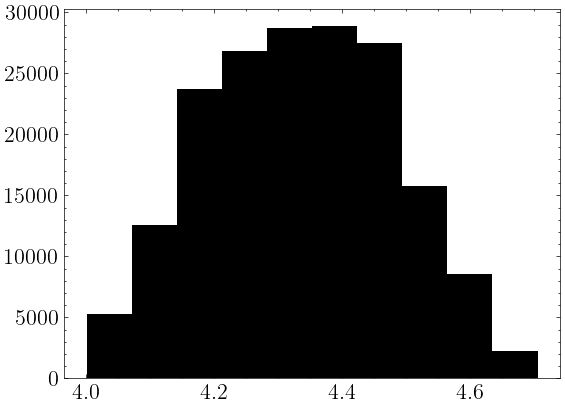

In [294]:
plt.hist(flat_samples_mix['logT_p1'])

In [295]:
np.median(flat_samples_mix['C_O_p1']), np.percentile(flat_samples_mix['logT_p1'], 100*(1-cdf_3sig))

(-0.1076771085834821, 4.03077781244141)

In [296]:
np.percentile(flat_samples_mix['log_metals_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_mix['log_metals_p2'], 100*cdf_3sig)

(-2.27479985187756, 0.7368052736416562)

Make a plot

In [298]:
logN_dict = {#'HI':'14.8, -0.1, +0.1',
            'HeI':'13.2, -0.1, +0.1',
            #'CII':'<13.8',
            'CIII':'14.0, -0.4, +0.5',
            'CIV':'13.64, -0.02, +0.02',
            'NIV':'13.02, -0.09, +0.09',
            'NV':'<13.3',
            'OIII':'14.33, -0.07, +0.07',
            'OIV':'14.46, -0.06, +0.06',
            'OV':'14.00, -0.02, +0.02',
            'OVI':'13.8, -0.1, +0.1',
            #'NeV':'<14.0',
            #'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            #'SiII':'<12.6',
            #'SIV':'<14.6',
            'SVI':'<13.3',}
            #'FeII':'<11.6'}

In [299]:
b_dict = {'HI':'19, -1, +1',
          'HeI': '10, -1, +1',
          'CIII':'6.7, -0.2, +0.2',
          'CIV':'6.7, -0.2, +0.2',
          'NIV':'6.7, -0.2, +0.2',
          'OIII':'6.7, -0.2, +0.2',
          'OIV':'6.7, -0.2, +0.2',
          'OV':'23, -1, +1',
          'OVI':'23, -1, +1'}

In [300]:
# Best-fit model prediction

logN_species_p1_best = predict_col_dens_model_TDP(logN_dict,
                                               np.median(flat_samples_mix['log_metals_p1']),
                                               np.median(flat_samples_mix['log_hdens_p1']),
                                               np.median(flat_samples_mix['logT_p1']),
                                               logN_HI_test,
                                               logX_dict_TDP_interp,
                                               np.median(flat_samples_mix['C_O_p1']),
                                               np.median(flat_samples_mix['N_O_p1']))


logN_species_p2_best = predict_col_dens_model_TDP(logN_dict,
                                               np.median(flat_samples_mix['log_metals_p2']),
                                               np.median(flat_samples_mix['log_hdens_p2']),
                                               np.median(flat_samples_mix['logT_p2']),
                                               np.median(flat_samples_mix['logN_HI_p2']),
                                               logX_dict_TDP_interp,
                                               np.median(flat_samples_mix['C_O_p2']),
                                               np.median(flat_samples_mix['N_O_p2']))

logN_species_best = np.log10(10**logN_species_p1_best + 10**logN_species_p2_best)

In [301]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [302]:
logN_res_up = {k:'<1.1' for k in list(logN_res_dict.keys())}

#logN_res_up['CII'] = '<0.75'
logN_res_up['SVI'] = '<0.68'
logN_res_up['NV'] = '<0.68'

In [303]:
# Model curves for each step
logN_species_p1_grid = np.zeros((len(logN_dict), len(flat_samples_mix)))
logN_species_p2_grid = np.zeros((len(logN_dict), len(flat_samples_mix)))

ctr = 0

for i in range(len(ion_species_dict)):
    
    ion = list(ion_species_dict.keys())[i]
    
    if ion in list(logN_dict.keys()):
        s = ion_species_dict[ion] # Species, for PIE
        elem = ion_species_dict[ion].split('+')[0] # Element, for non-solar abundances
        
        logN_species_p1_grid[ctr,:] = predict_col_dens_TDP(ion, 
                                           flat_samples_mix['log_metals_p1'],
                                           flat_samples_mix['log_hdens_p1'],
                                           flat_samples_mix['logT_p1'],
                                           logN_HI_test,
                                           logX_dict_TDP_interp)        
        
        logN_species_p2_grid[ctr,:] = predict_col_dens_TDP(ion, 
                                           flat_samples_mix['log_metals_p2'],
                                           flat_samples_mix['log_hdens_p2'],
                                           flat_samples_mix['logT_p2'],
                                           flat_samples_mix['logN_HI_p2'],
                                           logX_dict_TDP_interp)
        
        if elem == 'C':
            logN_species_p1_grid[ctr,:] += flat_samples_mix['C_O_p1']
            logN_species_p2_grid[ctr,:] += flat_samples_mix['C_O_p2']
            
        if elem == 'N':
            logN_species_p1_grid[ctr,:] += flat_samples_mix['N_O_p1']
            logN_species_p2_grid[ctr,:] += flat_samples_mix['N_O_p2']
            
        ctr += 1

logN_species_grid = np.log10(10**logN_species_p1_grid + 10**logN_species_p2_grid)

In [304]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_p1_lo = np.percentile(flat_samples_mix['log_hdens_p1'], 100*(1-cdf_1sig))
log_hdens_p1_hi = np.percentile(flat_samples_mix['log_hdens_p1'], 100*cdf_1sig)

log_metals_p1_lo = np.percentile(flat_samples_mix['log_metals_p1'], 100*(1-cdf_1sig))
log_metals_p1_hi = np.percentile(flat_samples_mix['log_metals_p1'], 100*cdf_1sig)

C_O_p1_lo = np.percentile(flat_samples_mix['C_O_p1'], 100*(1-cdf_1sig))
C_O_p1_hi = np.percentile(flat_samples_mix['C_O_p1'], 100*cdf_1sig)

N_O_p1_lo = np.percentile(flat_samples_mix['N_O_p1'], 100*(1-cdf_1sig))
N_O_p1_hi = np.percentile(flat_samples_mix['N_O_p1'], 100*cdf_1sig)

log_hdens_p2_lo = np.percentile(flat_samples_mix['log_hdens_p2'], 100*(1-cdf_1sig))
log_hdens_p2_hi = np.percentile(flat_samples_mix['log_hdens_p2'], 100*cdf_1sig)

for i in range(len(flat_samples_mix)):
    log_hdens_p1 = flat_samples_mix['log_hdens_p1'][i]
    log_metals_p1 = flat_samples_mix['log_metals_p1'][i]
    C_O_p1 = flat_samples_mix['C_O_p1'][i]
    N_O_p1 = flat_samples_mix['N_O_p1'][i]
    log_hdens_p2 = flat_samples_mix['log_hdens_p2'][i]
    
    if log_hdens_p1_lo<log_hdens_p1<log_hdens_p1_hi and log_metals_p1_lo<log_metals_p1<log_metals_p1_hi and C_O_p1_lo<C_O_p1<C_O_p1_hi and N_O_p1_lo<N_O_p1<N_O_p1_hi and log_hdens_p2_lo<log_hdens_p2<log_hdens_p2_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

In [305]:
import matplotlib.lines as mlines

In [306]:
z_sys = 1.04430803

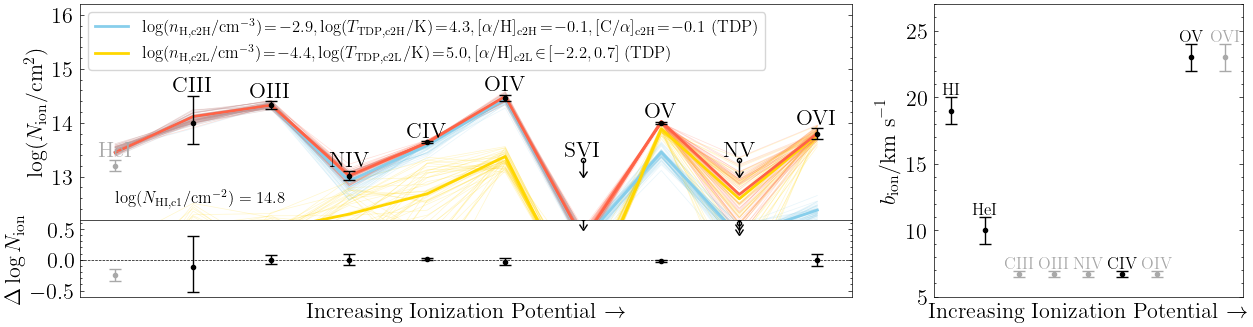

In [308]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.8), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p1_grid[:,filtered[idx]], color='skyblue', lw=.5, alpha=.2)
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p2_grid[:,filtered[idx]], color='gold', lw=.5, alpha=.2)
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p1_best, color='skyblue', lw=2)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p2_best, color='gold', lw=2)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)


plot_column_densities_obs(logN_dict, fig, axd['upper left'], gray_out=['HeI'])

axd['upper left'].set_ylim(12.2,16.2)

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, 
              label=r'$\log(n_\mathrm{H, c2H}/\mathrm{cm}^{-3}) \!=\! -2.9, \log(T_\mathrm{TDP,c2H}/\mathrm{K})\!=\!4.3,  \mathrm{[\alpha/H]_{c2H}}\!=\!-0.1, \mathrm{[C/\alpha]_{c2H}}\!=\!-0.1$ (TDP)'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2L}/\mathrm{cm}^{-3})\!=\!-4.4, \log(T_\mathrm{TDP,c2L}/\mathrm{K})\!=\!5.0, \mathrm{[\alpha/H]_{c2L}}\!\in\![-2.2,0.7]$ (TDP)'))
    
axd['upper left'].text(.0, 12.5, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.8$', fontsize=12,
            horizontalalignment='left')

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12, ncol=1)

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'], label_ions=False, dy=.1, c_dy=1.6, gray_out=['HeI'])
plot_column_densities_obs(logN_res_up, fig, axd['lower left'], label_ions=False, dy=.1, c_dy=1.6, gray_out=['HeI'])

axd['lower left'].set_ylim(-0.6,.65)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=12, gray_out = ['CIII', 'OIII', 'NIV', 'OIV', 'OVI', 'NeV'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(5,27)

plt.subplots_adjust(wspace=0.15, hspace=0) 

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_TDP+TDP_c1.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)
#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_TDP+TDP_c1.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

In [ ]:
logl_p1 = get_logl_TDP(p3_grid[:,0], p3_grid[:,1], p3_grid[:,2], 14.5, logX_dict_TDP_interp)
logl_p2 = get_logl_TDP(p3_grid[:,5], p3_grid[:,6], p3_grid[:,7], p3_grid[:,10], logX_dict_TDP_interp)

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logl_p1)

In [ ]:
get_quantiles(logl_p1)

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logl_p2)

In [ ]:
get_quantiles(logl_p2)

# DRAFT

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(3*3,3), sharex=True, sharey=True)

# Plot measurements

scat_logN_ratio(axes[0], 'CIV/CIII', 'OIV/OIII', logN_ratio_dict)
axes[0].set_title(r'$\mathrm{[O/H]}=-1.0$', fontsize=14)

scat_logN_ratio(axes[1], 'CIV/CIII', 'OIV/OIII', logN_ratio_dict)
axes[1].set_title(r'$\mathrm{[O/H]}=-0.3$', fontsize=14)

scat_logN_ratio(axes[2], 'CIV/CIII', 'OIV/OIII', logN_ratio_dict)
axes[2].set_title(r'$\mathrm{[O/H]}=0.0$', fontsize=14)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$', labelpad=25)
ax_label.set_ylabel(r'$\log(N_\mathrm{OIV}/N_\mathrm{OIII})$', labelpad=40)

plt.subplots_adjust(wspace=0, hspace=0.0)

# Plot tracks
# metals = -1.0

plot_logN_ratio_track(axes[0], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      -1.0, -2.8, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[0], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      -1.0, -3.1, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[0], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      -1.0, -3.3, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      ':', 'left', 'top')

axes[0].legend(fontsize=8)

# metals = -0.3

plot_logN_ratio_track(axes[1], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      -0.3, -2.8, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[1], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      -0.3, -3.1, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[1], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      -0.3, -3.3, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      ':', 'left', 'top')

# metals = 0.0

plot_logN_ratio_track(axes[2], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.0, -2.8, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[2], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.0, -3.1, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[2], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.0, -3.3, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      ':', 'left', 'top')

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(3*3,3), sharex=True, sharey=True)

# Plot measurements

scat_logN_ratio(axes[0], 'CIV/CIII', 'OIV/OIII', logN_ratio_dict)
axes[0].set_title(r'$\mathrm{[O/H]}=0.3$', fontsize=14)

scat_logN_ratio(axes[1], 'CIV/CIII', 'OIV/OIII', logN_ratio_dict)
axes[1].set_title(r'$\mathrm{[O/H]}=0.6$', fontsize=14)

scat_logN_ratio(axes[2], 'CIV/CIII', 'OIV/OIII', logN_ratio_dict)
axes[2].set_title(r'$\mathrm{[O/H]}=0.9$', fontsize=14)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$', labelpad=25)
ax_label.set_ylabel(r'$\log(N_\mathrm{OIV}/N_\mathrm{OIII})$', labelpad=40)

plt.subplots_adjust(wspace=0, hspace=0.0)

# Plot tracks
# metals = -1.0

plot_logN_ratio_track(axes[0], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.3, -2.8, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[0], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.3, -3.1, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[0], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.3, -3.3, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      ':', 'left', 'top')

axes[0].legend(fontsize=8)

# metals = -0.3

plot_logN_ratio_track(axes[1], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.6, -2.8, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[1], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.6, -3.1, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[1], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.6, -3.3, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      ':', 'left', 'top')

# metals = 0.0

plot_logN_ratio_track(axes[2], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.9, -2.8, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[2], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.9, -3.1, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[2], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.9, -3.3, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      ':', 'left', 'top')

## HI

In [ ]:
fig, ax = plt.subplots(1, figsize=(3,3))

logT_filt, logN_HI_filt = get_logN_HI('OIV', 14.47, -0.3, -3.0, logT_arr, logX_dict_TDP_interp)
ax.plot(logT_filt, logN_HI_filt,color='black', linestyle='--', label=r'$\mathrm{[O/H]}=-0.3$')

logT_filt, logN_HI_filt = get_logN_HI('OIV', 14.47, 0.0, -3.0, logT_arr, logX_dict_TDP_interp)
ax.plot(logT_filt, logN_HI_filt,color='purple', linestyle='--', label=r'$\mathrm{[O/H]}=0.0$')

logT_filt, logN_HI_filt = get_logN_HI('OIV', 14.47, 0.3, -3.0, logT_arr, logX_dict_TDP_interp)
ax.plot(logT_filt, logN_HI_filt,color='forestgreen', linestyle='--', label=r'$\mathrm{[O/H]}=0.3$')

ax.axhline(14.8, color='dodgerblue', lw=2)
ax.axhspan(14.7,14.9, color='dodgerblue',alpha=.3)
ax.axvline(4.5, color='orangered', lw=2, linestyle='--')

ax.set_xlim(4.0, 5.0)
ax.set_ylim(14, 16)

ax.legend(fontsize=10, loc='upper right')
ax.set_xlabel(r'$T \ (\mathrm{K})$')
ax.set_ylabel(r'$\log(N_\mathrm{HI}/\mathrm{cm}^{-2})$')

## Fit column densities

In [ ]:
def log_prior(log_metals, log_hdens, logT, C_O, N_O):
    
    if log_metals_arr[0]<log_metals<log_metals_arr[-1] and -3<log_metals+C_O<1 and -3<log_metals+N_O<1: #[C/H]
        if log_hdens_arr[0]<log_hdens<log_hdens_arr[-1]:
            if 4.1<logT<4.4: # Temperature limit based on CIV linewidth
                return np.log(10**log_hdens) + np.log(10**logT)
            else:
                return -np.inf
        else:
            return -np.inf
    else:
        return -np.inf

In [ ]:
def log_likelihood(log_metals, log_hdens, logT, C_O, N_O, logN_dict, logX_dict_TDP_interp):
    
    logN_HI_obs = 14.8 # Measured N(HI) to generate column densities
    
    ll = 0
    
    for ion in list(logN_dict.keys()):
        
        # Model side: prediction adjusted for elemental abundance
        elem = ion_species_dict[ion].split('+')[0]
        
        y_bar = predict_col_dens_TDP(ion, log_metals, log_hdens, logT, logN_HI_obs, logX_dict_TDP_interp)
        if elem == 'C':
            y_bar += C_O 
        if elem == 'N':
            y_bar += N_O
            
        # Data side: handle upper limits, lower limits, and measurements separately
        logN_str = logN_dict[ion]
        
        ll += compute_ll(logN_str, y_bar)

    return ll

In [ ]:
def log_probability(params, logN_dict, logX_dict_TDP_interp):
    
    log_metals, log_hdens, logT, C_O, N_O = params
    
    lp = log_prior(log_metals,log_hdens,logT,C_O,N_O)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp+log_likelihood(log_metals,log_hdens,logT,C_O,N_O,logN_dict,logX_dict_TDP_interp)

In [ ]:
logN_dict = {#'HI':'14.8, -0.1, +0.1',
        'HeI':'<13.1',
        'CII':'<13.0',
        'CIII':'13.9, -0.4, +0.5',
        'CIV':'13.62, -0.03, +0.03',
        'NIV':'13.0, -0.1, +0.1',
        'NV':'<13.3',
        'OIII':'14.33, -0.07, +0.07',
        'OIV':'14.47, -0.07, +0.07',
        'OV':'<14.01',
        'OVI':'<13.8',
        'NeV':'<13.7',
        'MgII':'<11.3',
        #'MgX':'<13.6',
        #'AlII':'<11.1',
        #'AlIII':'<11.5',
        'SiII':'<12.1',
        'SIV':'<13.9',
        'SVI':'<13.3',}
        #'FeII':'<11.6',}

In [ ]:
log_metals_test = -0.2
log_hdens_test = -3.0
logT_test = 4.3
logN_HI_test = 14.8
C_O_test = -0.2
N_O_test = -0.6

logN_test = predict_col_dens_model_TDP(logN_dict,log_metals_test,log_hdens_test,logT_test,logN_HI_test,logX_dict_TDP_interp, C_O_test, N_O_test)

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,2))

plot_column_densities_obs(logN_dict, fig, ax)

ax.plot(np.arange(len(logN_dict)), logN_test, color='orangered')
#ax.set_ylim(12.5,14)

In [ ]:
logN_test[0]

In [ ]:
pos = np.array([log_metals_test, log_hdens_test, logT_test, C_O_test, N_O_test]) + 1e-4 * np.random.randn(200, 5)
nwalkers, ndim = pos.shape

In [ ]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, logX_dict_TDP_interp)
)

In [ ]:
#sampler.run_mcmc(pos, 500, progress=True);

In [ ]:
#flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_metals', 'log_hdens', 'logT', 'C_O', 'N_O'])
#flat_samples.to_csv(savedir+'TDP_c1.csv', index=False)

flat_samples = pd.read_csv(savedir+'TDP_c1.csv')

In [ ]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\mathrm{[O/H]}$', r'$\log(n_\mathrm{H})$', r'$\log(T)$', r'$\mathrm{[C/O]}$',r'$\mathrm{[N/O]}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [ ]:
np.percentile(flat_samples['logT'], 100*cdf_3sig)

In [ ]:
plt.hist(flat_samples['log_metals']+flat_samples['N_O'])

In [ ]:
np.percentile(flat_samples['N_O'], 100*cdf_3sig)

Make a plot

In [ ]:
logN_dict = {#'HI':'14.8, -0.1, +0.2',
        'HeI':'<13.1',
        'CII':'<13.0',
        'CIII':'13.9, -0.4, +0.5',
        'CIV':'13.62, -0.03, +0.03',
        'NIV':'13.0, -0.1, +0.1',
        'NV':'<13.3',
        'OIII':'14.33, -0.07, +0.07',
        'OIV':'14.47, -0.07, +0.07',
        'OV':'14.01, -0.05, +0.08',
        'OVI':'13.8, -0.2, +0.1',
        'NeV':'<13.7',
        'MgII':'<11.3',
        #'MgX':'<13.6',
        #'AlII':'<11.1',
        #'AlIII':'<11.5',
        'SiII':'<12.1',
        'SIV':'<13.9',
        'SVI':'<13.3',}
        #'FeII':'<11.6',}

In [ ]:
b_dict = {'HI':'19, -1, +1',
          'CIII':'6.8, -0.2, +0.2',
          'CIV':'6.8, -0.2, +0.2',
          'NIV':'6.8, -0.2, +0.2',
          'OIII':'6.8, -0.2, +0.2',
          'OIV':'6.8, -0.2, +0.2',
          'OV':'18, -3, +2',
          'OVI':'18, -3, +2'}

In [ ]:
p_grid = np.array(flat_samples)

yb_med = np.zeros(len(logN_dict))
yb_lo = np.zeros(len(logN_dict))
yb_hi = np.zeros(len(logN_dict))

ctr = 0

for i in range(len(ion_species_dict)):
    
    ion = list(ion_species_dict.keys())[i]
    elem = ion_species_dict[ion].split('+')[0]
    
    if ion in list(logN_dict.keys()):
        
        y_samples = predict_col_dens_TDP(ion, p_grid[:,0], p_grid[:,1], p_grid[:,2], 14.8, logX_dict_TDP_interp)
        if elem == 'C':
            y_samples += p_grid[:,3]
        if elem == 'N':
            y_samples += p_grid[:,4]

        yb_med[ctr] = np.median(y_samples)
        yb_lo[ctr] = np.percentile(y_samples, 16)
        yb_hi[ctr] = np.percentile(y_samples, 84)
        
        ctr += 1

In [ ]:
import matplotlib.lines as mlines

In [ ]:
z_sys = 1.04430667

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,2.5))

plot_column_densities_obs(logN_dict, fig, ax,
                   gray_out = ['NV', 'OV', 'OVI', 'NeV','SVI'])

ax.plot(np.arange(len(logN_dict)), yb_med, lw=3, color='tomato')
ax.fill_between(np.arange(len(logN_dict)), yb_lo, yb_hi, color='tomato', alpha=.3)

ax.set_ylim(10.5,15.9)

ax.text(len(logN_dict)-1, 15.0, r'TDP', fontsize=14,horizontalalignment='right')

ax.text(len(logN_dict)-1, 11.3, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.8 \pm 0.1$', fontsize=12,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H,c1}/\mathrm{cm}^{-3}) = -2.99 \pm 0.09$'))

ax.legend(handles=handles, loc='upper left', fontsize=10)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_c1_TDP.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)
plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_c1_TDP.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

In [ ]:
yb_med[0]

Cloud size posterior

In [ ]:
logl = get_logl_TDP(p_grid[:,0], p_grid[:,1], p_grid[:,2], 14.8, logX_dict_TDP_interp)

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logl)

In [ ]:
get_quantiles(logl)

In [ ]:
logN_dict = {#'HI':'14.5, -0.1, +0.1',
            'HeI':'<13.1',
            'CII':'<13.0',
            'CIII':'13.1, -0.4, +0.3',
            'CIV':'13.52, -0.03, +0.03',
            'NIV':'13.0, -0.1, +0.1',
            'NV':'<13.3',
            'OIII':'13.6, -0.1, +0.1',
            'OIV':'13.9, -0.2, +0.1',
            'OV':'13.6, -0.2, +0.1',
            'OVI':'<13.8',
            'NeV':'<13.7',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.1',
            'SIV':'<13.9',
            'SVI':'<13.3',}
            #'FeII':'<11.6',}

In [ ]:
b_dict = {'HI':'22, -5, +5',
          'CIII':'8.2, -0.6, +0.6',
          'CIV':'8.2, -0.6, +0.6',
          'NIV':'8.2, -0.6, +0.6',
          'OIII':'8.2, -0.6, +0.6',
          'OIV':'8.2, -0.6, +0.6',
          'OV':'17, -3, +4'}

In [ ]:
p3_grid = np.array(flat_samples_3)

yb_med_p1 = np.zeros(len(logN_dict))
yb_lo_p1 = np.zeros(len(logN_dict))
yb_hi_p1 = np.zeros(len(logN_dict))

yb_med_p2 = np.zeros(len(logN_dict))
yb_lo_p2 = np.zeros(len(logN_dict))
yb_hi_p2 = np.zeros(len(logN_dict))

yb_med = np.zeros(len(logN_dict))
yb_lo = np.zeros(len(logN_dict))
yb_hi = np.zeros(len(logN_dict))

ctr = 0

for i in range(len(ion_species_dict)):
    
    ion = list(ion_species_dict.keys())[i]
    
    if ion in list(logN_dict.keys()):
        elem = ion_species_dict[ion].split('+')[0]

        y_samples_p1 = predict_col_dens_TDP(ion, p3_grid[:,0], p3_grid[:,1], p3_grid[:,2], 14.5, logX_dict_TDP_interp)
        y_samples_p2 = predict_col_dens_TDP(ion, p3_grid[:,5], p3_grid[:,6], p3_grid[:,7], p3_grid[:,10], logX_dict_TDP_interp)
        
        if elem == 'C':
            y_samples_p1 += p3_grid[:,3]
            y_samples_p2 += p3_grid[:,8]
            
        if elem == 'N':
            y_samples_p1 += p3_grid[:,4]
            y_samples_p2 += p3_grid[:,9]
            
        y_samples = np.log10(10**y_samples_p1 + 10**y_samples_p2) 
        
        yb_med_p1[ctr] = np.median(y_samples_p1)
        yb_lo_p1[ctr] = np.percentile(y_samples_p1, 16)
        yb_hi_p1[ctr] = np.percentile(y_samples_p1, 84)
        
        yb_med_p2[ctr] = np.median(y_samples_p2)
        yb_lo_p2[ctr] = np.percentile(y_samples_p2, 16)
        yb_hi_p2[ctr] = np.percentile(y_samples_p2, 84)
        
        yb_med[ctr] = np.median(y_samples)
        yb_lo[ctr] = np.percentile(y_samples, 16)
        yb_hi[ctr] = np.percentile(y_samples, 84)
        
        ctr += 1

In [ ]:
import matplotlib.lines as mlines

In [ ]:
z_sys = 1.04430667

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,2.5))

plot_column_densities_obs(logN_dict, fig, ax,
                          gray_out = ['NV', 'OV', 'OVI', 'NeV', 'SVI'])

ax.plot(np.arange(len(logN_dict)), yb_med_p1, lw=3, color='skyblue')
ax.fill_between(np.arange(len(logN_dict)), yb_lo_p1, yb_hi_p1, color='skyblue', alpha=.3)

ax.plot(np.arange(len(logN_dict)), yb_med_p2, lw=3, color='gold')
ax.fill_between(np.arange(len(logN_dict)), yb_lo_p2, yb_hi_p2, color='gold', alpha=.3)

ax.plot(np.arange(len(logN_dict)), yb_med, lw=3, color='orangered')
ax.fill_between(np.arange(len(logN_dict)), yb_lo, yb_hi, color='tomato', alpha=.3)

ax.set_ylim(10.5,15.9)

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1L}/\mathrm{cm}^{-3}) = -3.2_{-0.1}^{+0.2}$'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1H}/\mathrm{cm}^{-3}) = -3.52 \pm 0.07$'))
    
ax.text(len(logN_dict)-1, 15.0, r'TDP',fontsize=14, horizontalalignment='right')
ax.text(len(logN_dict)-1, 11.3, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.5 \pm 0.1$', fontsize=12,
            horizontalalignment='right')

ax.legend(handles=handles, loc='upper left', fontsize=10)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_c4_TDP.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)
plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_c4_TDP.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

In [ ]:
yb_med_p2[-10], yb_med_p2[-10]-yb_lo_p2[-10], yb_hi_p2[-10]-yb_med_p2[-10]

## Fit column densities (PIE+TDP)

### OIV, OV, OVI diagnostic

In [99]:
logN_dict = {#'HI':'14.8, -0.1, +0.1',
            #'HeI':'13.2, -0.1, +0.1',
            #'CII':'<13.8',
            #'CIII':'14.0, -0.4, +0.5',
            #'CIV':'13.64, -0.02, +0.02',
            #'NIV':'13.02, -0.09, +0.09',
            #'NV':'<13.3',
            #'OIII':'14.33, -0.07, +0.07',
            'OIV':'14.46, -0.06, +0.06',
            'OV':'14.00, -0.02, +0.02',
            'OVI':'13.8, -0.1, +0.1',}
            #'NeV':'<14.0',
            #'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            #'SiII':'<12.6',
            #'SIV':'<14.6',
            #'SVI':'<13.3',
            #'FeII':'<11.6'}

In [100]:
gen_logN_ratio_str(logN_dict['OV'], logN_dict['OIV'])

'-0.46, -0.06, 0.06'

In [101]:
logN_ratio_dict = {'OV/OIV': '-0.46, -0.06, 0.06',
                   'OVI/OV': '-0.20, -0.10, 0.10',
                  }

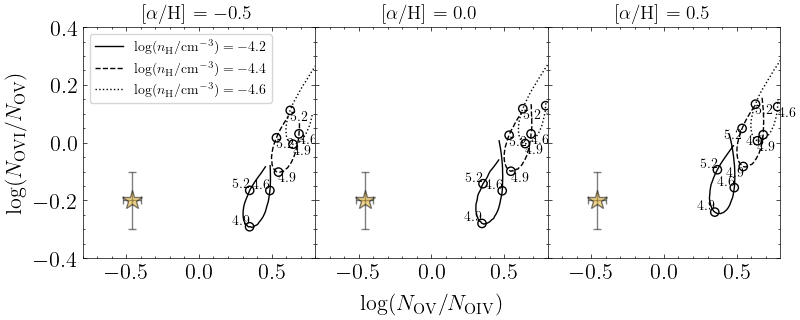

In [103]:
fig, axes = plt.subplots(1,3,figsize=(3*3,3), sharex=True, sharey=True)

# Plot measurements

scat_logN_ratio(axes[0], 'OV/OIV', 'OVI/OV', logN_ratio_dict)
axes[0].set_title(r'$\mathrm{[\alpha/H]}=-0.5$', fontsize=14)

scat_logN_ratio(axes[1], 'OV/OIV', 'OVI/OV', logN_ratio_dict)
axes[1].set_title(r'$\mathrm{[\alpha/H]}=0.0$', fontsize=14)

scat_logN_ratio(axes[2], 'OV/OIV', 'OVI/OV', logN_ratio_dict)
axes[2].set_title(r'$\mathrm{[\alpha/H]}=0.5$', fontsize=14)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'$\log(N_\mathrm{OV}/N_\mathrm{OIV})$', labelpad=25)
ax_label.set_ylabel(r'$\log(N_\mathrm{OVI}/N_\mathrm{OV})$', labelpad=40)

plt.subplots_adjust(wspace=0, hspace=0.0)

# Plot tracks
# metals = -0.5

plot_logN_ratio_track(axes[0], 'OIV', 'OV', 'OV', 'OVI', logX_dict_TDP_interp,
                      -0.5, -4.2, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.8, 0.8, -0.4, 0.4,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[0], 'OIV', 'OV', 'OV', 'OVI', logX_dict_TDP_interp,
                      -0.5, -4.4, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.8, 0.8, -0.4, 0.4,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[0], 'OIV', 'OV', 'OV', 'OVI', logX_dict_TDP_interp,
                      -0.5, -4.6, 
                      4.0, 5.5, .01,
                      4.0, 5.3, .3,
                      -0.8, 0.8, -0.4, 0.4,
                      ':', 'left', 'top')

axes[0].legend(fontsize=10)

# metals = -0.3

plot_logN_ratio_track(axes[1], 'OIV', 'OV', 'OV', 'OVI', logX_dict_TDP_interp,
                      0.0, -4.2, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.8, 0.8, -0.4, 0.4,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[1], 'OIV', 'OV', 'OV', 'OVI', logX_dict_TDP_interp,
                      0.0, -4.4, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.8, 0.8, -0.4, 0.4,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[1], 'OIV', 'OV', 'OV', 'OVI', logX_dict_TDP_interp,
                      0.0, -4.6, 
                      4.0, 5.5, .01,
                      4.0, 5.3, .3,
                      -0.8, 0.8, -0.4, 0.4,
                      ':', 'left', 'top')

# metals = 0.0

plot_logN_ratio_track(axes[2], 'OIV', 'OV', 'OV', 'OVI', logX_dict_TDP_interp,
                      0.5, -4.2, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.8, 0.8, -0.4, 0.4,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[2], 'OIV', 'OV', 'OV', 'OVI', logX_dict_TDP_interp,
                      0.5, -4.4, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.8, 0.8, -0.4, 0.4,
                      '--', 'right', 'top')

plot_logN_ratio_track(axes[2], 'OIV', 'OV', 'OV', 'OVI', logX_dict_TDP_interp,
                      0.5, -4.6, 
                      4.0, 5.5, .01,
                      4.0, 5.3, .3,
                      -0.8, 0.8, -0.4, 0.4,
                      ':', 'left', 'top')

#plt.savefig(savedir+'z_104_c1L_diagnostic.pdf', dpi=300)
#plt.savefig(savedir+'z_104_c1L_diagnostic.png', dpi=300)

### Fit

Load PIE grid, obtain the UVB grid from FG20

In [ ]:
fg20_z_grid, fg20_wav_grid, fg20_J_nu_grid = read_uvb('', 'fg20_galaxy.ascii')

Fetch the SED at $z=1$

In [ ]:
z_test = 1

In [ ]:
fg20_J_nu_test = fetch_sed(z_test, fg20_z_grid, fg20_J_nu_grid)

Specify $N_{\mathrm{HI}}$ grid points and get corresponding filenames

In [ ]:
logN_HI_min = 12
logN_HI_max = 17
logN_HI_step = 0.25

logN_HI_arr = np.arange(logN_HI_min, logN_HI_max+logN_HI_step, logN_HI_step)

In [ ]:
file_list = create_grid_file_list(logN_HI_arr)

Specify grid points for densities and metallicities

In [ ]:
log_hdens_min = -5
log_hdens_max = 1
log_hdens_step = 0.25

log_hdens_arr = np.arange(log_hdens_min, log_hdens_max+log_hdens_step, log_hdens_step)
logU_arr = np.log10(calc_U(fg20_wav_grid, fg20_J_nu_test, 10**log_hdens_arr))

In [ ]:
log_metals_min = -3
log_metals_max = 1
log_metals_step = 0.25

log_metals_arr = np.arange(log_metals_min, log_metals_max+log_metals_step, log_metals_step)

Load the final grid

In [ ]:
pkl_file = open(rootdir+'final_grid.pkl', 'rb')
species_logN_samples = pickle.load(pkl_file)
pkl_file.close()

Interpolate this grid

In [ ]:
species_logN_interp = {}

for s in list(species_logN_samples.keys()):
    
    species_logN_samples[s][species_logN_samples[s]==-np.inf] = -99
    
    species_logN_interp[s] = RegularGridInterpolator((logN_HI_arr, log_hdens_arr, log_metals_arr), 
                                                     species_logN_samples[s])

Dictionary of column densities

In [ ]:
logN_dict = {'HI':'14.8, -0.1, +0.1',
            #'HeI':'13.2, -0.1, +0.1',
            'CII':'<13.8',
            'CIII':'14.0, -0.4, +0.5',
            'CIV':'13.64, -0.02, +0.02',
            'NIV':'13.02, -0.09, +0.09',
            'NV':'<13.3',
            'OIII':'14.33, -0.07, +0.07',
            'OIV':'14.46, -0.06, +0.06',
            'OV':'14.00, -0.02, +0.02',
            'OVI':'13.8, -0.1, +0.1',
            'NeV':'<14.0',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',
            'SVI':'<13.3',}
            #'FeII':'<11.6'}

Test a solution

In [ ]:
# Dense PIE phase
logN_HI_test = 14.8
log_hdens_test_p1 = -3.0
log_metals_test_p1 = 0.0
C_O_test_p1 = -0.2
N_O_test_p1 = -0.5

logN_test_p1 = np.array(predict_col_dens(logN_dict, 
                                                 logN_HI_test, 
                                                 log_hdens_test_p1, 
                                                 log_metals_test_p1, 
                                                 species_logN_interp,
                                                 {'C': C_O_test_p1, 'N': N_O_test_p1}))

# Diffuse TDP phase
log_metals_test_p2 = -1.5
log_hdens_test_p2 = -4.4
logT_test_p2 = 4.9
C_O_test_p2 = -1.3
N_O_test_p2 = -1.3
logN_HI_test_p2 = 14.0

logN_test_p2 = predict_col_dens_model_TDP(logN_dict,log_metals_test_p2,log_hdens_test_p2,logT_test_p2,logN_HI_test_p2,logX_dict_TDP_interp,C_O_test_p2,N_O_test_p2)

Total column density yield

In [ ]:
logN_test = np.log10(10**logN_test_p1 + 10**logN_test_p2)

Make a test plot

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,2))

plot_column_densities_obs(logN_dict, fig, ax)
ax.plot(np.arange(len(logN_dict)), logN_test_p1, color='skyblue')
ax.plot(np.arange(len(logN_dict)), logN_test_p2, color='gold')
ax.plot(np.arange(len(logN_dict)), logN_test, color='orangered')

ax.set_ylim(12,16)

Attempt to fit

In [ ]:
log_metals_arr = [-2.6,-2.4,-2.2,-2.0,-1.8,-1.6,-1.4,-1.2,-1.0 ,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0]
log_hdens_arr = [-4.8,-4.4,-4.2,-4.0,-3.8,-3.6,-3.4,-3.2,-3.0,-2.8,-2.6,-2.4,-2.2,-2.0,-1.8,-1.6]
logT_arr = np.arange(4.00, 6.01, 0.01)

In [ ]:
def log_prior_mix(log_metals_p1, log_hdens_p1, C_O_p1, N_O_p1,
                log_metals_p2, log_hdens_p2, logT_p2, C_O_p2, N_O_p2, logN_HI_p2, species_logN_interp, logX_dict_TDP_interp):
        
    logN_HI_obs = logN_HI_test
    
    if log_metals_arr[0]<log_metals_p1<log_metals_arr[-1] and log_metals_arr[0]<log_metals_p2<log_metals_arr[-1]:
        if -3<log_metals_p1+C_O_p1<1 and C_O_p1 < 1.5 and -3<log_metals_p2+C_O_p2<1 and -3<log_metals_p1+N_O_p1<1 and -3<log_metals_p2+N_O_p2<1:
            if log_hdens_arr[0]<log_hdens_p1<log_hdens_arr[-1] and log_hdens_arr[0]<log_hdens_p2<log_hdens_arr[-1]:
                if 4.0<logT_p2<5.8: # Temperature limits based on HI/CIV linewidth
                    if 12.0<logN_HI_p2<logN_HI_obs:
                        if log_hdens_p1>log_hdens_p2: # CIV denser and colder
                            
                            # PIE cloud size
                            logl_p1 = np.log10(get_cloud_size(logN_HI_obs, log_hdens_p1, species_logN_interp, log_metals_p1))
                            # TDP cloud size
                            logl_p2 = get_logl_TDP(log_metals_p2, log_hdens_p2, logT_p2, logN_HI_p2, logX_dict_TDP_interp)
                                                        
                            # Limits for diffuse cloud size
                            logl_p2_S = np.log10(0.03*(10**log_hdens_p2/1e-3)**-1) # in kpc
                            logl_p2_J = np.log10(40*(10**log_hdens_p2/1e-3)**-0.5*(10**logT_p2/1e4)**0.5) # added scaling for temperature
                            
                            if logl_p1<logl_p2 and logl_p2_S<logl_p2<logl_p2_J:
                                
                                return np.log(10**logN_HI_p2) # log10 to linear, then natural log

                            else:
                                return -np.inf
                        else:
                            return -np.inf
                    else:
                        return -np.inf
                else:
                    return -np.inf
            else:
                return -np.inf
        else:
            return -np.inf
    else:
        return -np.inf

In [ ]:
def log_likelihood_mix(log_metals_p1, log_hdens_p1, C_O_p1, N_O_p1,
                     log_metals_p2, log_hdens_p2, logT_p2, C_O_p2, N_O_p2, logN_HI_p2,
                     logN_dict, species_logN_interp, logX_dict_TDP_interp):
    
    logN_HI_obs = logN_HI_test # Measured N(HI) to generate column densities
    
    ll = 0
    
    for ion in list(logN_dict.keys()):
        
        # Model side: prediction adjusted for elemental abundance
        s = ion_species_dict[ion] # Species, for PIE
        
        # PIE prediction
        if ion != 'HI':
            y_bar_p1 = species_logN_interp[s]([logN_HI_obs, log_hdens_p1, log_metals_p1])[0]
        else:
            y_bar_p1 = logN_HI_obs
        
        # TDP prediction
        elem = ion_species_dict[ion].split('+')[0] # Element, for TDP
        y_bar_p2 = predict_col_dens_TDP(ion, log_metals_p2, log_hdens_p2, logT_p2, logN_HI_p2, logX_dict_TDP_interp)
        
        # Account for non-solar abundance pattern
        if elem == 'C': 
            y_bar_p1 += C_O_p1
            y_bar_p2 += C_O_p2
            
        if elem == 'N':
            y_bar_p1 += N_O_p1
            y_bar_p2 += N_O_p2
          
        y_bar = np.log10(10**y_bar_p1 + 10**y_bar_p2)
            
        # Data side: handle upper limits, lower limits, and measurements separately
        logN_str = logN_dict[ion]
        
        ll += compute_ll(logN_str, y_bar)

    return ll

In [ ]:
def log_probability_mix(params, logN_dict, species_logN_interp, logX_dict_TDP_interp):
    
    log_metals_p1,log_hdens_p1,C_O_p1,N_O_p1,log_metals_p2,log_hdens_p2,logT_p2,C_O_p2,N_O_p2,logN_HI_p2 = params
    
    lp = log_prior_mix(log_metals_p1,log_hdens_p1,C_O_p1,N_O_p1,log_metals_p2,log_hdens_p2,logT_p2,C_O_p2,N_O_p2,logN_HI_p2,species_logN_interp,logX_dict_TDP_interp)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp+log_likelihood_mix(log_metals_p1,log_hdens_p1,C_O_p1,N_O_p1,log_metals_p2,log_hdens_p2,logT_p2,C_O_p2,N_O_p2,logN_HI_p2,logN_dict,species_logN_interp,logX_dict_TDP_interp)

MCMC fit

In [ ]:
pos = np.array([log_metals_test_p1,log_hdens_test_p1,C_O_test_p1,N_O_test_p1, 
                log_metals_test_p2,log_hdens_test_p2,logT_test_p2,C_O_test_p2,N_O_test_p2,logN_HI_test_p2]) + 1e-4 * np.random.randn(200, 10)
nwalkers, ndim = pos.shape

In [ ]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_mix, args=(logN_dict,species_logN_interp,logX_dict_TDP_interp)
)

In [ ]:
#sampler.run_mcmc(pos, 1000, progress=True);

In [106]:
#flat_samples_mix = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_metals_p1','log_hdens_p1','C_O_p1','N_O_p1',
#                                         'log_metals_p2','log_hdens_p2','logT_p2','C_O_p2','N_O_p2','logN_HI_p2'])
#flat_samples_mix.to_csv(savedir+'PIE+TDP_c1.csv', index=False)

flat_samples_mix = pd.read_csv(savedir+'PIE+TDP_c1.csv')

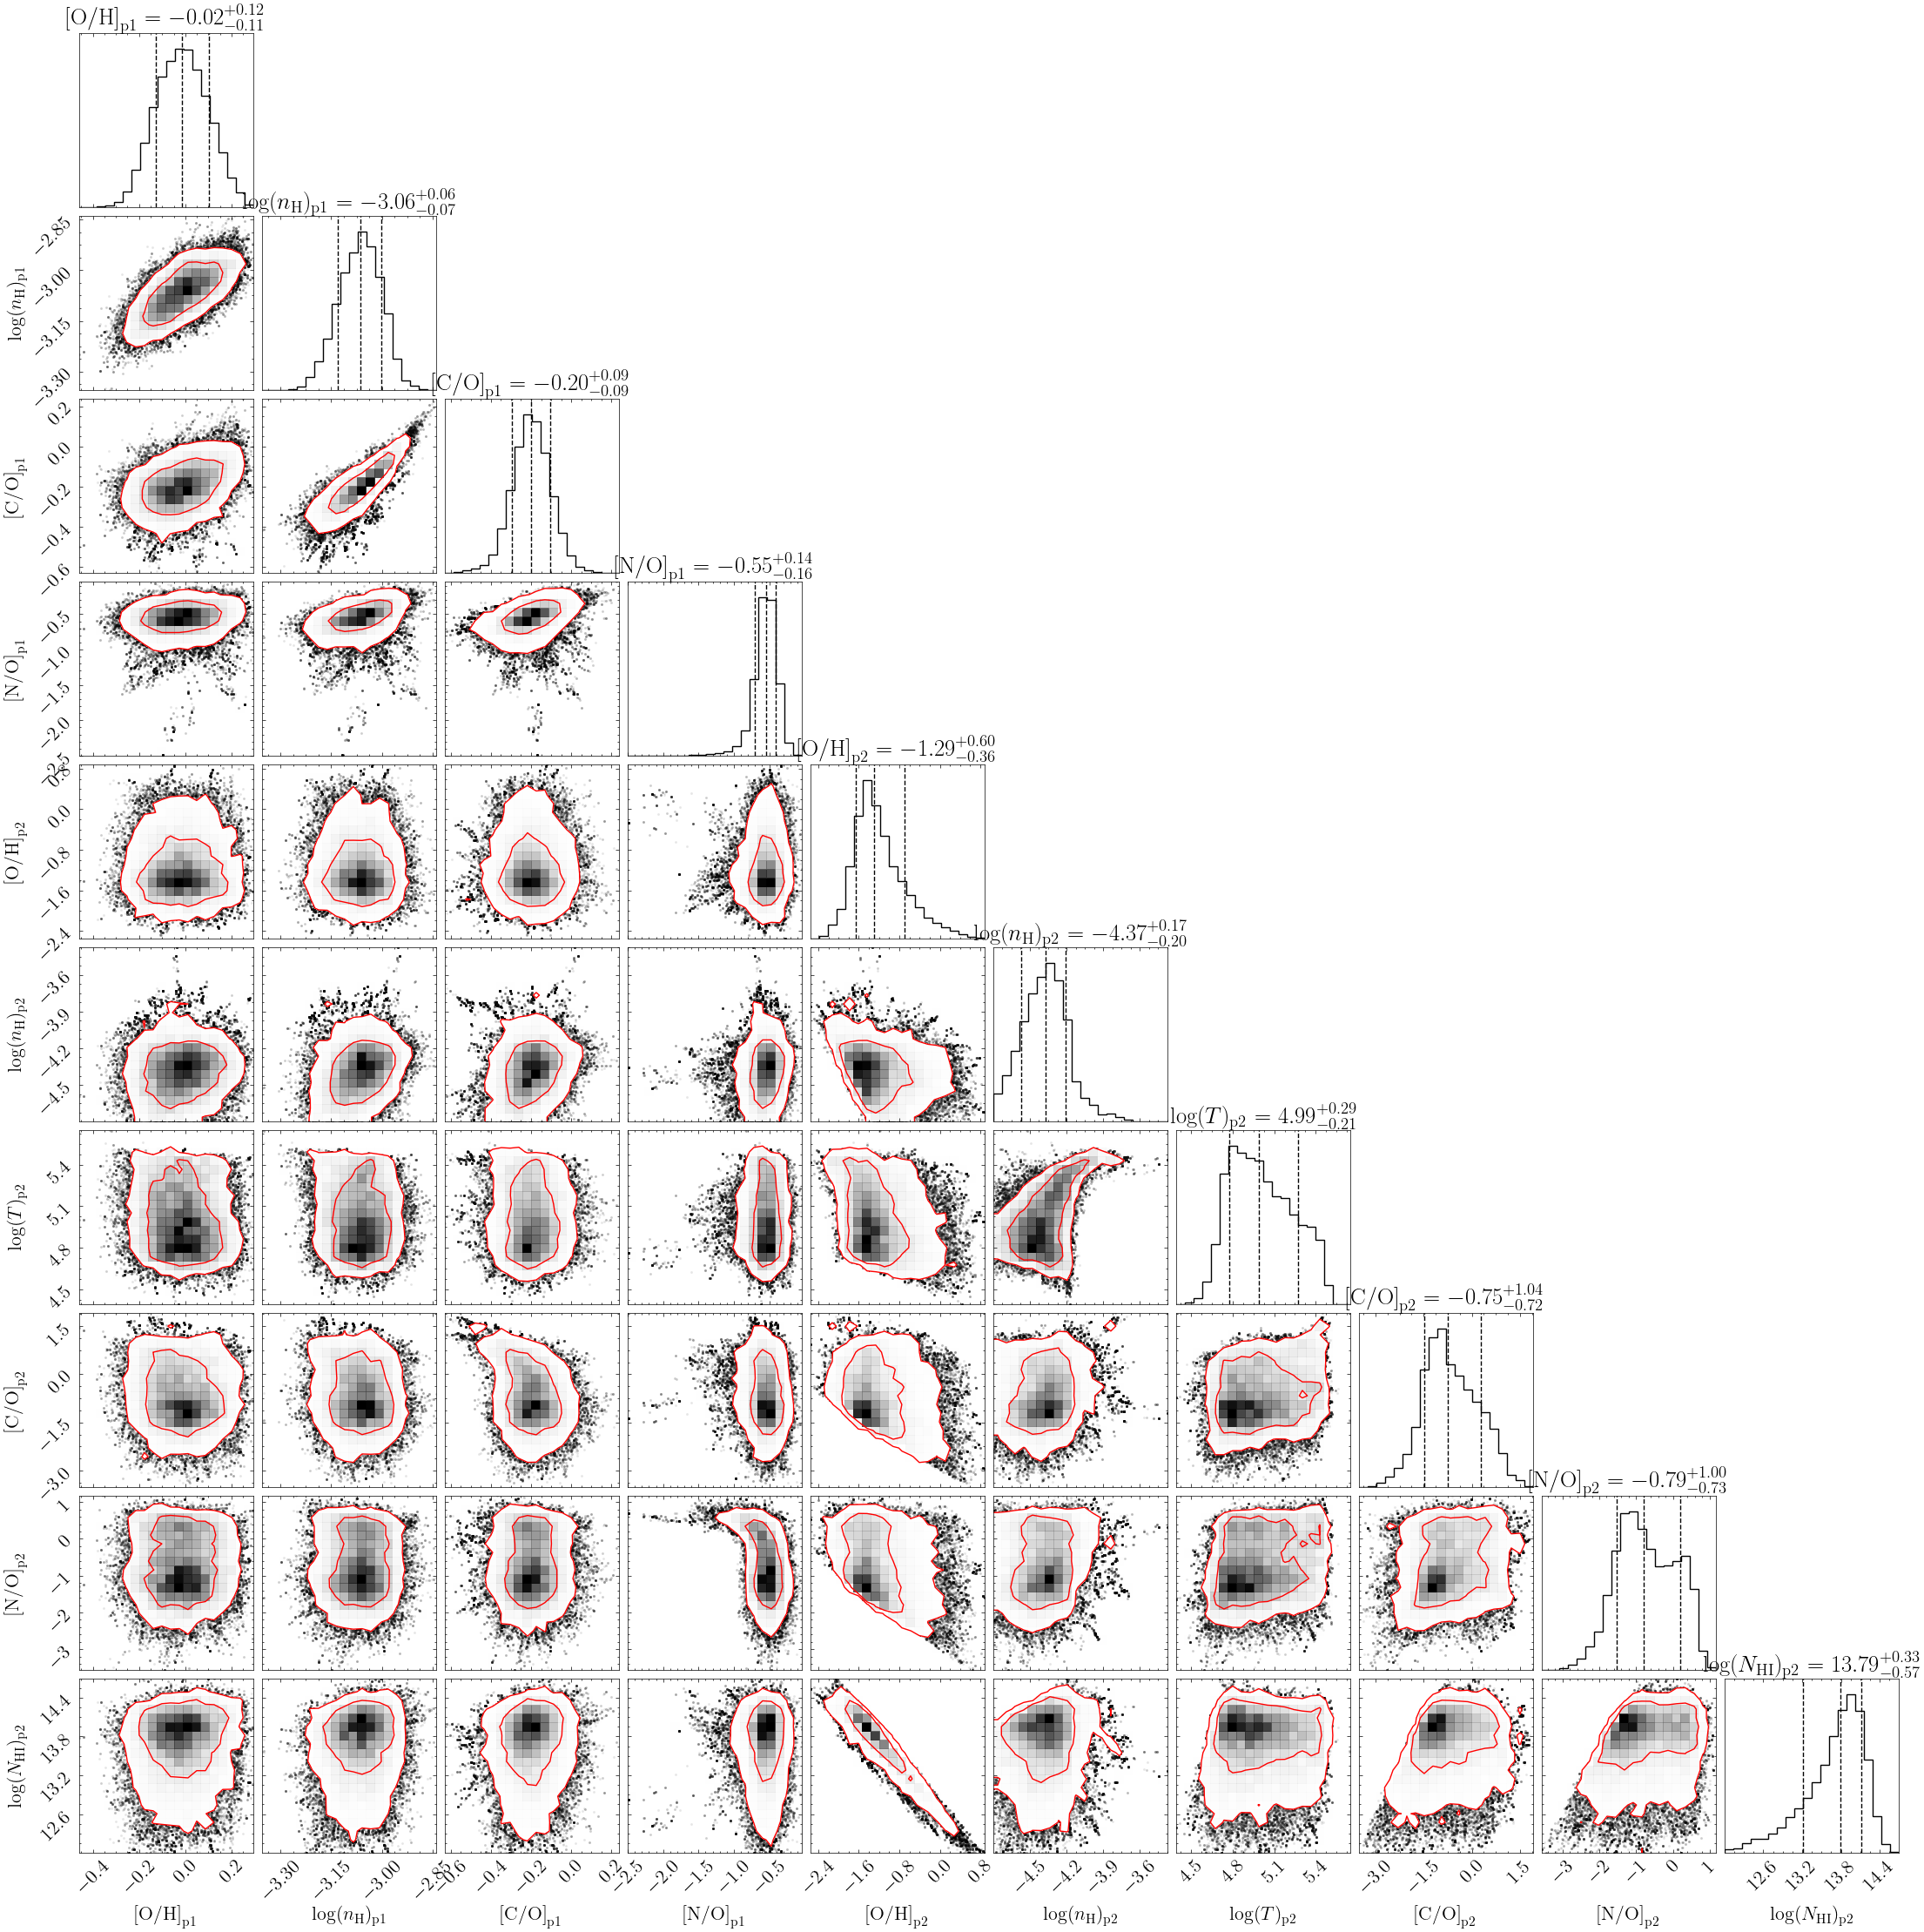

In [107]:
fig = corner.corner(
    flat_samples_mix, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\mathrm{[O/H]}_\mathrm{p1}$',r'$\log(n_\mathrm{H})_\mathrm{p1}$',r'$\mathrm{[C/O]}_\mathrm{p1}$',r'$\mathrm{[N/O]}_\mathrm{p1}$',
            r'$\mathrm{[O/H]}_\mathrm{p2}$',r'$\log(n_\mathrm{H})_\mathrm{p2}$',r'$\log(T)_\mathrm{p2}$',r'$\mathrm{[C/O]}_\mathrm{p2}$',r'$\mathrm{[N/O]}_\mathrm{p2}$',
            r'$\log(N_\mathrm{HI})_\mathrm{p2}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [ ]:
np.median(flat_samples_mix['N_O_p1'])

In [ ]:
np.percentile(flat_samples_mix['logN_HI_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_mix['logN_HI_p2'], 100*cdf_3sig)

In [ ]:
np.percentile(flat_samples_mix['log_metals_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_mix['log_metals_p2'], 100*cdf_3sig)

In [ ]:
np.percentile(flat_samples_mix['C_O_p2'], 100*cdf_3sig), np.percentile(flat_samples_mix['N_O_p2'], 100*cdf_3sig)

### Plot

In [ ]:
logN_dict = {#'HI':'14.8, -0.1, +0.1',
            'HeI':'13.2, -0.1, +0.1',
            #'CII':'<13.8',
            'CIII':'14.0, -0.4, +0.5',
            'CIV':'13.64, -0.02, +0.02',
            'NIV':'13.02, -0.09, +0.09',
            'NV':'<13.3',
            'OIII':'14.33, -0.07, +0.07',
            'OIV':'14.46, -0.06, +0.06',
            'OV':'14.00, -0.02, +0.02',
            'OVI':'13.8, -0.1, +0.1',
            #'NeV':'<14.0',
            #'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            #'SiII':'<12.6',
            #'SIV':'<14.6',
            'SVI':'<13.3',}
            #'FeII':'<11.6'}

In [ ]:
b_dict = {'HI':'19, -1, +1',
          'HeI': '10, -1, +1',
          'CIII':'6.7, -0.2, +0.2',
          'CIV':'6.7, -0.2, +0.2',
          'NIV':'6.7, -0.2, +0.2',
          'OIII':'6.7, -0.2, +0.2',
          'OIV':'6.7, -0.2, +0.2',
          'OV':'23, -1, +1',
          'OVI':'23, -1, +1'}

In [ ]:
# Best-fit model prediction

logN_species_p1_best = predict_col_dens(logN_dict, logN_HI_test, np.median(flat_samples_mix['log_hdens_p1']), 
                                        np.median(flat_samples_mix['log_metals_p1']), 
                                        species_logN_interp, {'C':np.median(flat_samples_mix['C_O_p1']), 
                                                              'N':np.median(flat_samples_mix['N_O_p1'])})
logN_species_p2_best = predict_col_dens_model_TDP(logN_dict,
                                               np.median(flat_samples_mix['log_metals_p2']),
                                               np.median(flat_samples_mix['log_hdens_p2']),
                                               np.median(flat_samples_mix['logT_p2']),
                                               np.median(flat_samples_mix['logN_HI_p2']),
                                               logX_dict_TDP_interp,
                                               np.median(flat_samples_mix['C_O_p2']),
                                               np.median(flat_samples_mix['N_O_p2']))

logN_species_best = np.log10(10**logN_species_p1_best + 10**logN_species_p2_best)

In [ ]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [ ]:
logN_res_up = {k:'<1.1' for k in list(logN_res_dict.keys())}

#logN_res_up['CII'] = '<0.75'
logN_res_up['SVI'] = '<0.68'
logN_res_up['NV'] = '<0.68'

In [ ]:
# Model curves for each step
logN_species_p1_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples_mix['log_hdens_p1'], 
                                        flat_samples_mix['log_metals_p1'], 
                                        species_logN_interp, 
                                        {'C':flat_samples_mix['C_O_p1'], 'N':flat_samples_mix['N_O_p1']})

logN_species_p2_grid = np.zeros(logN_species_p1_grid.shape)

ctr = 0

for i in range(len(ion_species_dict)):
    
    ion = list(ion_species_dict.keys())[i]
    
    if ion in list(logN_dict.keys()):
        s = ion_species_dict[ion] # Species, for PIE
        elem = ion_species_dict[ion].split('+')[0] # Element, for non-solar abundances
        
        logN_species_p2_grid[ctr,:] = predict_col_dens_TDP(ion, 
                                           flat_samples_mix['log_metals_p2'],
                                           flat_samples_mix['log_hdens_p2'],
                                           flat_samples_mix['logT_p2'],
                                           flat_samples_mix['logN_HI_p2'],
                                           logX_dict_TDP_interp)
        
        if elem == 'C':
            logN_species_p2_grid[ctr,:] += flat_samples_mix['C_O_p2']
            
        if elem == 'N':
            logN_species_p2_grid[ctr,:] += flat_samples_mix['N_O_p2']
            
        ctr += 1

logN_species_grid = np.log10(10**logN_species_p1_grid + 10**logN_species_p2_grid)

In [ ]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_p1_lo = np.percentile(flat_samples_mix['log_hdens_p1'], 100*(1-cdf_1sig))
log_hdens_p1_hi = np.percentile(flat_samples_mix['log_hdens_p1'], 100*cdf_1sig)

log_metals_p1_lo = np.percentile(flat_samples_mix['log_metals_p1'], 100*(1-cdf_1sig))
log_metals_p1_hi = np.percentile(flat_samples_mix['log_metals_p1'], 100*cdf_1sig)

C_O_p1_lo = np.percentile(flat_samples_mix['C_O_p1'], 100*(1-cdf_1sig))
C_O_p1_hi = np.percentile(flat_samples_mix['C_O_p1'], 100*cdf_1sig)

N_O_p1_lo = np.percentile(flat_samples_mix['N_O_p1'], 100*(1-cdf_1sig))
N_O_p1_hi = np.percentile(flat_samples_mix['N_O_p1'], 100*cdf_1sig)

log_hdens_p2_lo = np.percentile(flat_samples_mix['log_hdens_p2'], 100*(1-cdf_1sig))
log_hdens_p2_hi = np.percentile(flat_samples_mix['log_hdens_p2'], 100*cdf_1sig)

for i in range(len(flat_samples_mix)):
    log_hdens_p1 = flat_samples_mix['log_hdens_p1'][i]
    log_metals_p1 = flat_samples_mix['log_metals_p1'][i]
    C_O_p1 = flat_samples_mix['C_O_p1'][i]
    N_O_p1 = flat_samples_mix['N_O_p1'][i]
    log_hdens_p2 = flat_samples_mix['log_hdens_p2'][i]
    
    if log_hdens_p1_lo<log_hdens_p1<log_hdens_p1_hi and log_metals_p1_lo<log_metals_p1<log_metals_p1_hi and C_O_p1_lo<C_O_p1<C_O_p1_hi and N_O_p1_lo<N_O_p1<N_O_p1_hi and log_hdens_p2_lo<log_hdens_p2<log_hdens_p2_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

In [ ]:
import matplotlib.lines as mlines

In [ ]:
z_sys = 1.04430803

In [ ]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.8), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p1_grid[:,filtered[idx]], color='skyblue', lw=.5, alpha=.2)
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p2_grid[:,filtered[idx]], color='gold', lw=.5, alpha=.2)
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p1_best, color='skyblue', lw=2)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p2_best, color='gold', lw=2)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)


plot_column_densities_obs(logN_dict, fig, axd['upper left'], gray_out=['HeI'])

axd['upper left'].set_ylim(12.2,16.2)

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, 
              label=r'$\log(n_\mathrm{H, c2H}/\mathrm{cm}^{-3}) \!=\! -3.1, \mathrm{[\alpha/H]_{c2H}}\!=\!0.0, \mathrm{[C/\alpha]_{c2H}}\!=\!-0.2$ (PIE)'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2L}/\mathrm{cm}^{-3})\!=\!-4.4, \log(T_\mathrm{TDP,c2L}/\mathrm{K})\!=\!5.0, \mathrm{[\alpha/H]_{c2L}}\!\in\![-2.3,0.7]$ (TDP)'))
    
axd['upper left'].text(.0, 12.5, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.8$', fontsize=12,
            horizontalalignment='left')

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12, ncol=1)

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'], label_ions=False, dy=.1, c_dy=1.6, gray_out=['HeI'])
plot_column_densities_obs(logN_res_up, fig, axd['lower left'], label_ions=False, dy=.1, c_dy=1.6, gray_out=['HeI'])

axd['lower left'].set_ylim(-0.6,.65)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=12, gray_out = ['CIII', 'OIII', 'NIV', 'OIV', 'OVI', 'NeV'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(5,27)

plt.subplots_adjust(wspace=0.15, hspace=0) 

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_PIE+TDP_c1.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)
plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_PIE+TDP_c1.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

In [ ]:
logl_p1 = np.log10(get_cloud_size(logN_HI_test, flat_samples_mix['log_hdens_p1'], species_logN_interp, 
                                  flat_samples_mix['log_metals_p1'])) # PIE
logl_p2 = get_logl_TDP(flat_samples_mix['log_metals_p2'], flat_samples_mix['log_hdens_p2'], 
                       flat_samples_mix['logT_p2'], flat_samples_mix['logN_HI_p2'], logX_dict_TDP_interp) # TDP

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logl_p1)
ax.set_xlabel(r'$\log(l_\mathrm{p1}/\mathrm{kpc})$')

In [ ]:
get_quantiles(logl_p1)

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logl_p2)

In [ ]:
get_quantiles(logl_p2)

In [ ]:
np.percentile(logl_p2, 100*(1-cdf_3sig)), np.percentile(logl_p2, 100*cdf_3sig)

In [ ]:
get_logl_TDP(0.0, -4.4, 5.0, 14.8, logX_dict_TDP_interp)

In [ ]:
np.log10(40*(10**-4.8/1e-3)**-0.5*(10**5.0/1e4)**0.5) # added scaling for temperature

## Fit column densities (TDP+TDP)

### CIII, CIV, OIII, OIV diagnostic

In [ ]:
logN_dict = {#'HI':'14.8, -0.1, +0.1',
            #'HeI':'13.2, -0.1, +0.1',
            #'CII':'<13.8',
            'CIII':'14.0, -0.4, +0.5',
            'CIV':'13.64, -0.02, +0.02',
            #'NIV':'13.02, -0.09, +0.09',
            #'NV':'<13.3',
            'OIII':'14.33, -0.07, +0.07',
            'OIV':'14.46, -0.06, +0.06',}
            #'OV':'14.00, -0.02, +0.02',
            #'OVI':'13.8, -0.1, +0.1',}
            #'NeV':'<14.0',
            #'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            #'SiII':'<12.6',
            #'SIV':'<14.6',
            #'SVI':'<13.3',
            #'FeII':'<11.6'}

In [ ]:
gen_logN_ratio_str(logN_dict['CIV'], logN_dict['OIII'])

In [ ]:
logN_ratio_dict = {'CIV/CIII': '-0.36, -0.40, 0.50',
                   'OIV/OIII': '0.13, -0.09, 0.09',
                   'CIV/OIII': '-0.69, -0.07, 0.07'
                  }

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(3*3,3), sharex=True, sharey=True)

# Plot measurements

scat_logN_ratio(axes[0], 'OIV/OIII', 'CIV/CIII', logN_ratio_dict)
axes[0].set_title(r'$\mathrm{[\alpha/H]}=-0.5$', fontsize=14)

scat_logN_ratio(axes[1], 'OIV/OIII', 'CIV/CIII', logN_ratio_dict)
axes[1].set_title(r'$\mathrm{[\alpha/H]}=0.0$', fontsize=14)

scat_logN_ratio(axes[2], 'OIV/OIII', 'CIV/CIII', logN_ratio_dict)
axes[2].set_title(r'$\mathrm{[\alpha/H]}=0.5$', fontsize=14)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'$\log(N_\mathrm{OIV}/N_\mathrm{OIII})$', labelpad=25)
ax_label.set_ylabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$', labelpad=40)

plt.subplots_adjust(wspace=0, hspace=0.0)

# Plot tracks
# metals = -0.5

plot_logN_ratio_track(axes[0], 'OIII', 'OIV', 'CIII', 'CIV', logX_dict_TDP_interp,
                      -0.5, -2.9, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[0], 'OIII', 'OIV', 'CIII', 'CIV', logX_dict_TDP_interp,
                      -0.5, -3.1, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[0], 'OIII', 'OIV', 'CIII', 'CIV', logX_dict_TDP_interp,
                      -0.5, -3.3, 
                      4.0, 5.5, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      ':', 'left', 'top')

axes[0].legend(fontsize=10)

# metals = -0.3

plot_logN_ratio_track(axes[1], 'OIII', 'OIV', 'CIII', 'CIV', logX_dict_TDP_interp,
                      0.0, -2.9, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[1], 'OIII', 'OIV', 'CIII', 'CIV', logX_dict_TDP_interp,
                      0.0, -3.1, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[1], 'OIII', 'OIV', 'CIII', 'CIV', logX_dict_TDP_interp,
                      0.0, -3.3, 
                      4.0, 5.5, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      ':', 'left', 'top')

# metals = 0.0

plot_logN_ratio_track(axes[2], 'OIII', 'OIV', 'CIII', 'CIV', logX_dict_TDP_interp,
                      0.5, -2.9, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[2], 'OIII', 'OIV', 'CIII', 'CIV', logX_dict_TDP_interp,
                      0.5, -3.1, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      '--', 'right', 'top')

plot_logN_ratio_track(axes[2], 'OIII', 'OIV', 'CIII', 'CIV', logX_dict_TDP_interp,
                      0.5, -3.3, 
                      4.0, 5.5, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      ':', 'left', 'top')

#plt.savefig(savedir+'z_104_c1H_diagnostic.pdf', dpi=300)
#plt.savefig(savedir+'z_104_c1H_diagnostic.png', dpi=300)

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(3*3,3), sharex=True, sharey=True)

# Plot measurements

scat_logN_ratio(axes[0], 'OIV/OIII', 'CIV/OIII', logN_ratio_dict)
axes[0].set_title(r'$\mathrm{[\alpha/H]}=-0.5$', fontsize=14)

scat_logN_ratio(axes[1], 'OIV/OIII', 'CIV/OIII', logN_ratio_dict)
axes[1].set_title(r'$\mathrm{[\alpha/H]}=0.0$', fontsize=14)

scat_logN_ratio(axes[2], 'OIV/OIII', 'CIV/OIII', logN_ratio_dict)
axes[2].set_title(r'$\mathrm{[\alpha/H]}=0.5$', fontsize=14)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'$\log(N_\mathrm{OIV}/N_\mathrm{OIII})$', labelpad=25)
ax_label.set_ylabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{OIII})$', labelpad=40)

plt.subplots_adjust(wspace=0, hspace=0.0)

# Plot tracks
# metals = -0.5

plot_logN_ratio_track(axes[0], 'OIII', 'OIV', 'OIII', 'CIV', logX_dict_TDP_interp,
                      -0.5, -2.9, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[0], 'OIII', 'OIV', 'OIII', 'CIV', logX_dict_TDP_interp,
                      -0.5, -3.1, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[0], 'OIII', 'OIV', 'OIII', 'CIV', logX_dict_TDP_interp,
                      -0.5, -3.3, 
                      4.0, 5.5, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      ':', 'left', 'top')

axes[0].legend(fontsize=10)

# metals = -0.3

plot_logN_ratio_track(axes[1], 'OIII', 'OIV', 'OIII', 'CIV', logX_dict_TDP_interp,
                      0.0, -2.9, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[1], 'OIII', 'OIV', 'OIII', 'CIV', logX_dict_TDP_interp,
                      0.0, -3.1, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[1], 'OIII', 'OIV', 'OIII', 'CIV', logX_dict_TDP_interp,
                      0.0, -3.3, 
                      4.0, 5.5, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      ':', 'left', 'top')

# metals = 0.0

plot_logN_ratio_track(axes[2], 'OIII', 'OIV', 'OIII', 'CIV', logX_dict_TDP_interp,
                      0.5, -2.9, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[2], 'OIII', 'OIV', 'OIII', 'CIV', logX_dict_TDP_interp,
                      0.5, -3.1, 
                      4.0, 5.3, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      '--', 'right', 'top')

plot_logN_ratio_track(axes[2], 'OIII', 'OIV', 'OIII', 'CIV', logX_dict_TDP_interp,
                      0.5, -3.3, 
                      4.0, 5.5, .01,
                      4.0, 5.3, .3,
                      -0.3, 0.5, -0.8, 0.7,
                      ':', 'left', 'top')

#plt.savefig(savedir+'z_104_c1H_diagnostic.pdf', dpi=300)
#plt.savefig(savedir+'z_104_c1H_diagnostic.png', dpi=300)

### Fit

# c4

## Make diagnostics

In [ ]:
logN_dict = {#'HI':'14.5, -0.1, +0.1',
            #'HeI':'<13.1',
            #'CII':'<13.0',
            'CIII':'13.1, -0.4, +0.3',
            'CIV':'13.52, -0.03, +0.03',
            #'NIV':'13.0, -0.1, +0.1',
            #'NV':'<13.3',
            'OIII':'13.6, -0.1, +0.1',
            'OIV':'13.9, -0.2, +0.1',}
            #'OV':'13.6, -0.2, +0.1',
            #'OVI':'<13.8',
            #'NeV':'<13.7',
            #'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            #'SiII':'<12.1',
            #'SIV':'<13.9',
            #'SVI':'<13.3',
            #'FeII':'<11.6',}

## CIII, CIV, OIV

In [ ]:
gen_logN_ratio_str(logN_dict['OIV'], logN_dict['OIII'])

In [ ]:
logN_ratio_dict = {'CIV/CIII': '0.42, -0.40, 0.30',
                   'OIV/OIII': '0.30, -0.22, 0.14',
                  }

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(3*3,3), sharex=True, sharey=True)

# Plot measurements

scat_logN_ratio(axes[0], 'CIV/CIII', 'OIV/OIII', logN_ratio_dict)
axes[0].set_title(r'$\mathrm{[O/H]}=-1.0$', fontsize=14)

scat_logN_ratio(axes[1], 'CIV/CIII', 'OIV/OIII', logN_ratio_dict)
axes[1].set_title(r'$\mathrm{[O/H]}=-0.3$', fontsize=14)

scat_logN_ratio(axes[2], 'CIV/CIII', 'OIV/OIII', logN_ratio_dict)
axes[2].set_title(r'$\mathrm{[O/H]}=0.0$', fontsize=14)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$', labelpad=25)
ax_label.set_ylabel(r'$\log(N_\mathrm{OIV}/N_\mathrm{OIII})$', labelpad=40)

plt.subplots_adjust(wspace=0, hspace=0.0)

# Plot tracks
# metals = -1.0

plot_logN_ratio_track(axes[0], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      -1.0, -2.8, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      0.0,1.0, 0.0,1.0,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[0], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      -1.0, -3.1, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      0.0,1.0, 0.0,1.0,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[0], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      -1.0, -3.3, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      0.0,1.0, 0.0,1.0,
                      ':', 'left', 'top')

axes[0].legend(fontsize=8)

# metals = -0.3

plot_logN_ratio_track(axes[1], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      -0.3, -2.8, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      0.0,1.0, 0.0,1.0,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[1], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      -0.3, -3.1, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      0.0,1.0, 0.0,1.0,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[1], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      -0.3, -3.3, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      0.0,1.0, 0.0,1.0,
                      ':', 'left', 'top')

# metals = 0.0

plot_logN_ratio_track(axes[2], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.0, -2.8, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      0.0,1.0, 0.0,1.0,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[2], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.0, -3.1, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      0.0,1.0, 0.0,1.0,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[2], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.0, -3.3, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      0.0,1.0, 0.0,1.0,
                      ':', 'left', 'top')

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(3*3,3), sharex=True, sharey=True)

# Plot measurements

scat_logN_ratio(axes[0], 'CIV/CIII', 'OIV/OIII', logN_ratio_dict)
axes[0].set_title(r'$\mathrm{[O/H]}=0.3$', fontsize=14)

scat_logN_ratio(axes[1], 'CIV/CIII', 'OIV/OIII', logN_ratio_dict)
axes[1].set_title(r'$\mathrm{[O/H]}=0.6$', fontsize=14)

scat_logN_ratio(axes[2], 'CIV/CIII', 'OIV/OIII', logN_ratio_dict)
axes[2].set_title(r'$\mathrm{[O/H]}=0.9$', fontsize=14)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$', labelpad=25)
ax_label.set_ylabel(r'$\log(N_\mathrm{OIV}/N_\mathrm{OIII})$', labelpad=40)

plt.subplots_adjust(wspace=0, hspace=0.0)

# Plot tracks
# metals = -1.0

plot_logN_ratio_track(axes[0], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.3, -2.8, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[0], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.3, -3.1, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[0], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.3, -3.3, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      ':', 'left', 'top')

axes[0].legend(fontsize=8)

# metals = -0.3

plot_logN_ratio_track(axes[1], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.6, -2.8, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[1], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.6, -3.1, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[1], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.6, -3.3, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      ':', 'left', 'top')

# metals = 0.0

plot_logN_ratio_track(axes[2], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.9, -2.8, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[2], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.9, -3.1, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[2], 'CIII', 'CIV', 'OIII', 'OIV', logX_dict_TDP_interp,
                      0.9, -3.3, 
                      4.0, 5.0, .01,
                      4.0, 5.0, .3,
                      -0.59,-0.01, 0.0,0.5,
                      ':', 'left', 'top')

## HI

In [ ]:
fig, ax = plt.subplots(1, figsize=(3,3))

logT_filt, logN_HI_filt = get_logN_HI('OIV', 14.47, -0.3, -3.0, logT_arr, logX_dict_TDP_interp)
ax.plot(logT_filt, logN_HI_filt,color='black', linestyle='--', label=r'$\mathrm{[O/H]}=-0.3$')

logT_filt, logN_HI_filt = get_logN_HI('OIV', 14.47, 0.0, -3.0, logT_arr, logX_dict_TDP_interp)
ax.plot(logT_filt, logN_HI_filt,color='purple', linestyle='--', label=r'$\mathrm{[O/H]}=0.0$')

logT_filt, logN_HI_filt = get_logN_HI('OIV', 14.47, 0.3, -3.0, logT_arr, logX_dict_TDP_interp)
ax.plot(logT_filt, logN_HI_filt,color='forestgreen', linestyle='--', label=r'$\mathrm{[O/H]}=0.3$')

ax.axhline(14.8, color='dodgerblue', lw=2)
ax.axhspan(14.7,14.9, color='dodgerblue',alpha=.3)
ax.axvline(4.5, color='orangered', lw=2, linestyle='--')

ax.set_xlim(4.0, 5.0)
ax.set_ylim(14, 16)

ax.legend(fontsize=10, loc='upper right')
ax.set_xlabel(r'$T \ (\mathrm{K})$')
ax.set_ylabel(r'$\log(N_\mathrm{HI}/\mathrm{cm}^{-2})$')

## Fit column densities - two phase

In [ ]:
def log_prior_3(log_metals_p1, log_hdens_p1, logT_p1, C_O_p1, N_O_p1,
                log_metals_p2, log_hdens_p2, logT_p2, C_O_p2, N_O_p2, logN_HI_p2, logX_dict_TDP_interp):
        
    logN_HI_obs = 14.5
    
    if log_metals_arr[0]<log_metals_p1<log_metals_arr[-1] and log_metals_arr[0]<log_metals_p2<log_metals_arr[-1]:
        if -3<log_metals_p1+C_O_p1<1 and -3<log_metals_p2+C_O_p2<1 and -3<log_metals_p1+N_O_p1<1 and -3<log_metals_p2+N_O_p2<1:
            if log_hdens_arr[0]<log_hdens_p1<-2.3 and log_hdens_arr[0]<log_hdens_p2<log_hdens_arr[-1]:
                if 4.0<logT_p1<4.9 and 4.0<logT_p2<4.8: #
                    if 12.0<logN_HI_p2<logN_HI_obs:
                        if log_hdens_p1>log_hdens_p2 and logT_p1<logT_p2: # CIV denser and colder
                            logl_p1 = get_logl_TDP(log_metals_p1, log_hdens_p1, logT_p1, logN_HI_obs, logX_dict_TDP_interp)
                            logl_p2 = get_logl_TDP(log_metals_p2, log_hdens_p2, logT_p2, logN_HI_p2, logX_dict_TDP_interp)
                            if logl_p1 < logl_p2 < 2:
                                return np.log(10**log_hdens_p1) + np.log(10**logT_p1) + np.log(10**log_hdens_p2) + np.log(10**logT_p2) + np.log(10**logN_HI_p2)
                                #else:
                                #    return -np.inf
                            else:
                                return -np.inf
                        else:
                            return -np.inf
                    else:
                        return -np.inf
                else:
                    return -np.inf
            else:
                return -np.inf
        else:
            return -np.inf
    else:
        return -np.inf

In [ ]:
def log_likelihood_3(log_metals_p1, log_hdens_p1, logT_p1, C_O_p1, N_O_p1,
                     log_metals_p2, log_hdens_p2, logT_p2, C_O_p2, N_O_p2, logN_HI_p2,
                     logN_dict, logX_dict_TDP_interp):
    
    logN_HI_obs = 14.5 # Measured N(HI) to generate column densities
    
    ll = 0
    
    for ion in list(logN_dict.keys()):
        
        if ion == 'HI':
            # For HI there is nothing to bring from the grid
            y_bar_p1 = logN_HI_obs
            y_bar_p2 = logN_HI_p2
            
        else:
            # Model side: prediction adjusted for elemental abundance
            elem = ion_species_dict[ion].split('+')[0]

            y_bar_p1 = predict_col_dens_TDP(ion, log_metals_p1, log_hdens_p1, logT_p1, logN_HI_obs, logX_dict_TDP_interp)
            y_bar_p2 = predict_col_dens_TDP(ion, log_metals_p2, log_hdens_p2, logT_p2, logN_HI_p2, logX_dict_TDP_interp)

            if elem == 'C': 
                y_bar_p1 += C_O_p1
                y_bar_p2 += C_O_p2

            if elem == 'N':
                y_bar_p1 += N_O_p1
                y_bar_p2 += N_O_p2
          
        y_bar = np.log10(10**y_bar_p1 + 10**y_bar_p2)
            
        # Data side: handle upper limits, lower limits, and measurements separately
        logN_str = logN_dict[ion]
        
        ll += compute_ll(logN_str, y_bar)

    return ll

In [ ]:
def log_probability_3(params, logN_dict, logX_dict_TDP_interp):
    
    log_metals_p1,log_hdens_p1,logT_p1,C_O_p1,N_O_p1,log_metals_p2,log_hdens_p2,logT_p2,C_O_p2,N_O_p2,logN_HI_p2 = params
    
    lp = log_prior_3(log_metals_p1,log_hdens_p1,logT_p1,C_O_p1,N_O_p1,log_metals_p2,log_hdens_p2,logT_p2,C_O_p2,N_O_p2,logN_HI_p2,logX_dict_TDP_interp)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp+log_likelihood_3(log_metals_p1,log_hdens_p1,logT_p1,C_O_p1,N_O_p1,log_metals_p2,log_hdens_p2,logT_p2,C_O_p2,N_O_p2,logN_HI_p2,logN_dict,logX_dict_TDP_interp)

In [ ]:
logN_dict = {'HI':'14.5, -0.1, +0.1',
            'HeI':'<13.1',
            'CII':'<13.0',
            'CIII':'13.1, -0.4, +0.3',
            'CIV':'13.52, -0.03, +0.03',
            'NIV':'13.0, -0.1, +0.1',
            'NV':'<13.3',
            'OIII':'13.6, -0.1, +0.1',
            'OIV':'13.9, -0.2, +0.1',
            'OV':'<13.6',
            'OVI':'<13.8',
            'NeV':'<13.7',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.1',
            'SIV':'<13.9',
            'SVI':'<13.3',}
            #'FeII':'<11.6',}

In [ ]:
log_metals_test_p1 = -1.1
log_hdens_test_p1 = -3.0
logT_test_p1 = 4.4
C_O_test_p1 = -1.3
N_O_test_p1 = -1.3
logN_HI_test_p1 = 14.5

logN_test_p1 = predict_col_dens_model_TDP(logN_dict,log_metals_test_p1,log_hdens_test_p1,logT_test_p1,logN_HI_test_p1,logX_dict_TDP_interp,C_O_test_p1,N_O_test_p1)

log_metals_test_p2 = 0.0
log_hdens_test_p2 = -3.7
logT_test_p2 = 4.8
C_O_test_p2 = 0.6
N_O_test_p2 = 0.0
logN_HI_test_p2 = 13.0

logN_test_p2 = predict_col_dens_model_TDP(logN_dict,log_metals_test_p2,log_hdens_test_p2,logT_test_p2,logN_HI_test_p2,logX_dict_TDP_interp,C_O_test_p2,N_O_test_p2)

logN_test = np.log10(10**logN_test_p1 + 10**logN_test_p2)

In [ ]:
get_logl_TDP(log_metals_test_p1, log_hdens_test_p1, logT_test_p1, logN_HI_test_p1, logX_dict_TDP_interp)

In [ ]:
get_logl_TDP(log_metals_test_p2, log_hdens_test_p2, logT_test_p2, logN_HI_test_p2, logX_dict_TDP_interp)

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,2))

plot_column_densities_obs(logN_dict, fig, ax)
ax.plot(np.arange(len(logN_dict)), logN_test_p1, color='skyblue')
ax.plot(np.arange(len(logN_dict)), logN_test_p2, color='gold')
ax.plot(np.arange(len(logN_dict)), logN_test, color='orangered')

ax.set_ylim(12.,15)

In [ ]:
pos = np.array([log_metals_test_p1,log_hdens_test_p1,logT_test_p1,C_O_test_p1,N_O_test_p1, 
                log_metals_test_p2,log_hdens_test_p2,logT_test_p2,C_O_test_p2,N_O_test_p2,logN_HI_test_p2]) + 1e-4 * np.random.randn(200, 11)
nwalkers, ndim = pos.shape

In [ ]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_3, args=(logN_dict,logX_dict_TDP_interp)
)

In [ ]:
#sampler.run_mcmc(pos, 500, progress=True);

In [ ]:
#flat_samples_3 = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_metals_p1','log_hdens_p1','logT_p1','C_O_p1','N_O_p1',
#                                         'log_metals_p2','log_hdens_p2','logT_p2','C_O_p2','N_O_p2','logN_HI_p2'])
#flat_samples_3.to_csv(savedir+'TDP_c4.csv', index=False)

flat_samples_3 = pd.read_csv(savedir+'TDP_c4.csv')

In [ ]:
fig = corner.corner(
    flat_samples_3, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\mathrm{[O/H]}_\mathrm{p1}$',r'$\log(n_\mathrm{H})_\mathrm{p1}$',r'$\log(T)_\mathrm{p1}$',r'$\mathrm{[C/O]}_\mathrm{p1}$',r'$\mathrm{[N/O]}_\mathrm{p1}$',
            r'$\mathrm{[O/H]}_\mathrm{p2}$',r'$\log(n_\mathrm{H})_\mathrm{p2}$',r'$\log(T)_\mathrm{p2}$',r'$\mathrm{[C/O]}_\mathrm{p2}$',r'$\mathrm{[N/O]}_\mathrm{p2}$',
            r'$\log(N_\mathrm{HI})_\mathrm{p2}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [ ]:
np.percentile(flat_samples_3['logT_p1'], 100*cdf_3sig)

In [ ]:
plt.hist(flat_samples_3['log_metals_p2']+flat_samples_3['C_O_p2'])

In [ ]:
plt.hist(flat_samples_3['log_metals_p2']+flat_samples_3['N_O_p2'])

In [ ]:
np.percentile(flat_samples_3['C_O_p1'], 100*cdf_3sig), np.percentile(flat_samples_3['N_O_p1'], 100*cdf_3sig)

Make a plot

In [ ]:
logN_dict = {#'HI':'14.5, -0.1, +0.1',
            'HeI':'<13.1',
            'CII':'<13.0',
            'CIII':'13.1, -0.4, +0.3',
            'CIV':'13.52, -0.03, +0.03',
            'NIV':'13.0, -0.1, +0.1',
            'NV':'<13.3',
            'OIII':'13.6, -0.1, +0.1',
            'OIV':'13.9, -0.2, +0.1',
            'OV':'13.6, -0.2, +0.1',
            'OVI':'<13.8',
            'NeV':'<13.7',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.1',
            'SIV':'<13.9',
            'SVI':'<13.3',}
            #'FeII':'<11.6',}

In [ ]:
b_dict = {'HI':'22, -5, +5',
          'CIII':'8.2, -0.6, +0.6',
          'CIV':'8.2, -0.6, +0.6',
          'NIV':'8.2, -0.6, +0.6',
          'OIII':'8.2, -0.6, +0.6',
          'OIV':'8.2, -0.6, +0.6',
          'OV':'17, -3, +4'}

In [ ]:
p3_grid = np.array(flat_samples_3)

yb_med_p1 = np.zeros(len(logN_dict))
yb_lo_p1 = np.zeros(len(logN_dict))
yb_hi_p1 = np.zeros(len(logN_dict))

yb_med_p2 = np.zeros(len(logN_dict))
yb_lo_p2 = np.zeros(len(logN_dict))
yb_hi_p2 = np.zeros(len(logN_dict))

yb_med = np.zeros(len(logN_dict))
yb_lo = np.zeros(len(logN_dict))
yb_hi = np.zeros(len(logN_dict))

ctr = 0

for i in range(len(ion_species_dict)):
    
    ion = list(ion_species_dict.keys())[i]
    
    if ion in list(logN_dict.keys()):
        elem = ion_species_dict[ion].split('+')[0]

        y_samples_p1 = predict_col_dens_TDP(ion, p3_grid[:,0], p3_grid[:,1], p3_grid[:,2], 14.5, logX_dict_TDP_interp)
        y_samples_p2 = predict_col_dens_TDP(ion, p3_grid[:,5], p3_grid[:,6], p3_grid[:,7], p3_grid[:,10], logX_dict_TDP_interp)
        
        if elem == 'C':
            y_samples_p1 += p3_grid[:,3]
            y_samples_p2 += p3_grid[:,8]
            
        if elem == 'N':
            y_samples_p1 += p3_grid[:,4]
            y_samples_p2 += p3_grid[:,9]
            
        y_samples = np.log10(10**y_samples_p1 + 10**y_samples_p2) 
        
        yb_med_p1[ctr] = np.median(y_samples_p1)
        yb_lo_p1[ctr] = np.percentile(y_samples_p1, 16)
        yb_hi_p1[ctr] = np.percentile(y_samples_p1, 84)
        
        yb_med_p2[ctr] = np.median(y_samples_p2)
        yb_lo_p2[ctr] = np.percentile(y_samples_p2, 16)
        yb_hi_p2[ctr] = np.percentile(y_samples_p2, 84)
        
        yb_med[ctr] = np.median(y_samples)
        yb_lo[ctr] = np.percentile(y_samples, 16)
        yb_hi[ctr] = np.percentile(y_samples, 84)
        
        ctr += 1

In [ ]:
import matplotlib.lines as mlines

In [ ]:
z_sys = 1.04430667

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,2.5))

plot_column_densities_obs(logN_dict, fig, ax,
                          gray_out = ['NV', 'OV', 'OVI', 'NeV', 'SVI'])

ax.plot(np.arange(len(logN_dict)), yb_med_p1, lw=3, color='skyblue')
ax.fill_between(np.arange(len(logN_dict)), yb_lo_p1, yb_hi_p1, color='skyblue', alpha=.3)

ax.plot(np.arange(len(logN_dict)), yb_med_p2, lw=3, color='gold')
ax.fill_between(np.arange(len(logN_dict)), yb_lo_p2, yb_hi_p2, color='gold', alpha=.3)

ax.plot(np.arange(len(logN_dict)), yb_med, lw=3, color='orangered')
ax.fill_between(np.arange(len(logN_dict)), yb_lo, yb_hi, color='tomato', alpha=.3)

ax.set_ylim(10.5,15.9)

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1L}/\mathrm{cm}^{-3}) = -3.2_{-0.1}^{+0.2}$'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1H}/\mathrm{cm}^{-3}) = -3.52 \pm 0.07$'))
    
ax.text(len(logN_dict)-1, 15.0, r'TDP',fontsize=14, horizontalalignment='right')
ax.text(len(logN_dict)-1, 11.3, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.5 \pm 0.1$', fontsize=12,
            horizontalalignment='right')

ax.legend(handles=handles, loc='upper left', fontsize=10)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_c4_TDP.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)
plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_c4_TDP.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

In [ ]:
yb_med_p2[-10], yb_med_p2[-10]-yb_lo_p2[-10], yb_hi_p2[-10]-yb_med_p2[-10]

In [ ]:
logl_p1 = get_logl_TDP(p3_grid[:,0], p3_grid[:,1], p3_grid[:,2], 14.5, logX_dict_TDP_interp)
logl_p2 = get_logl_TDP(p3_grid[:,5], p3_grid[:,6], p3_grid[:,7], p3_grid[:,10], logX_dict_TDP_interp)

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logl_p1)

In [ ]:
get_quantiles(logl_p1)

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logl_p2)

In [ ]:
get_quantiles(logl_p2)

### Ionization correction

In [18]:
logN_dict = {#'HI':'14.8, -0.1, +0.1',
            #'HeI':'13.2, -0.1, +0.1',
            #'CII':'<13.8',
            'CIII':'14.0, -0.4, +0.5',
            'CIV':'13.64, -0.02, +0.02',
            #'NIV':'13.02, -0.09, +0.09',
            #'NV':'<13.3',
            'OIII':'14.33, -0.07, +0.07',
            'OIV':'14.46, -0.06, +0.06',
            'OV':'14.00, -0.02, +0.02',
            #'OVI':'13.8, -0.1, +0.1',}
            #'NeV':'<14.0',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.6',}
            #'SIV':'<14.6',
            #'SVI':'<13.3',
            #'FeII':'<11.6'}

In [19]:
gen_logN_ratio_str(logN_dict['OV'], logN_dict['OIV'])

'-0.46, -0.06, 0.06'

In [22]:
logN_ratio_dict = {'CIV/CIII': '-0.36, -0.40, 0.50',
                   'OIV/OIII': '0.13, -0.09, 0.09',
                   'MgII/OIII': '-3.03, -0.1, +0.1',
                   'CIV/OIII': '-0.69, -0.07, 0.07',
                   'OV/OIV': '-0.46, -0.06, 0.06'
                  }

In [47]:
log_hdens_arr = np.arange(-3.5, -2.5, 0.01)
log_metals_arr = np.array([-0.5, 0, 0.4])
logT_arr = np.array([4.1, 4.3, 4.5])

CO_PIE = np.zeros((len(log_hdens_arr), len(log_metals_arr)))
CO_TDP = np.zeros((len(log_hdens_arr), len(log_metals_arr), len(logT_arr)))

for i in range(len(log_hdens_arr)):
    for j in range(len(log_metals_arr)):
        x = log_hdens_arr[i]
        y = log_metals_arr[j]
        CO_PIE[i,j] = species_logN_interp['C+3']([12.0, x, y])-species_logN_interp['O+3']([12.0, x, y])
        
        for k in range(len(logT_arr)):

            z = logT_arr[k]
            CO_TDP[i,j,k] = logX_dict_TDP_interp['CIV']((y,x,z))-logX_dict_TDP_interp['OIV']((y,x,z))
            CO_TDP[i,j,k] += np.log10(solar_rel_dens_dict['C']/solar_rel_dens_dict['O'])

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_1925/2021565609.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  CO_PIE[i,j] = species_logN_interp['C+3']([12.0, x, y])-species_logN_interp['O+3']([12.0, x, y])


(-1.0, 0.0)

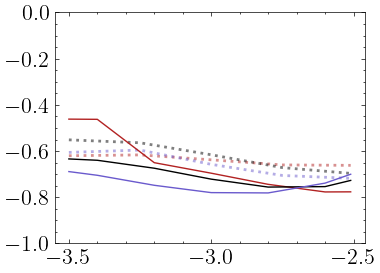

In [48]:
fig, ax = plt.subplots(1, figsize=(4,3))

plt.plot(log_hdens_arr, CO_PIE[:,0], color='firebrick', linestyle=':', lw=2, alpha=.5)
plt.plot(log_hdens_arr, CO_PIE[:,1], color='black', linestyle=':', lw=2, alpha=.5)
plt.plot(log_hdens_arr, CO_PIE[:,2], color='slateblue', linestyle=':', lw=2, alpha=.5)

#plt.plot(log_hdens_arr, CO_TDP[:,0,0], color='firebrick', linestyle=':')
plt.plot(log_hdens_arr, CO_TDP[:,0,1], color='firebrick', linestyle='-')
#plt.plot(log_hdens_arr, CO_TDP[:,0,2], color='firebrick', linestyle='--')

#plt.plot(log_hdens_arr, CO_TDP[:,1,0], color='black', linestyle=':')
plt.plot(log_hdens_arr, CO_TDP[:,1,1], color='black', linestyle='-')
#plt.plot(log_hdens_arr, CO_TDP[:,1,2], color='black', linestyle='--')

#plt.plot(log_hdens_arr, CO_TDP[:,2,0], color='slateblue', linestyle=':')
plt.plot(log_hdens_arr, CO_TDP[:,2,1], color='slateblue', linestyle='-')
#plt.plot(log_hdens_arr, CO_TDP[:,2,2], color='slateblue', linestyle='--')

plt.ylim(-1,0)

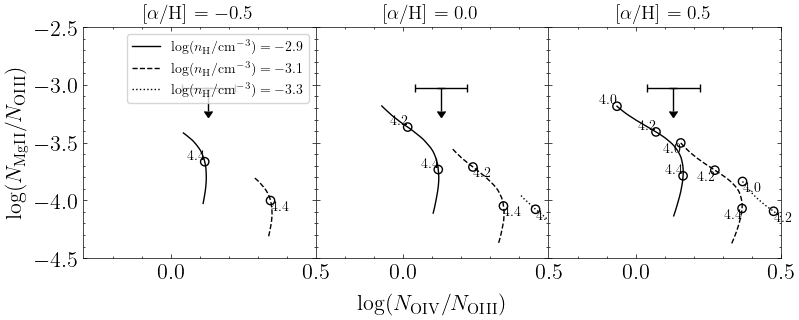

In [60]:
fig, axes = plt.subplots(1,3,figsize=(3*3,3), sharex=True, sharey=True)

# Plot measurements

axes[0].errorbar(0.13, -3.03, xerr=0.09, yerr=0.2, uplims=True, capsize=3)
axes[0].set_title(r'$\mathrm{[\alpha/H]}=-0.5$', fontsize=14)

axes[1].errorbar(0.13, -3.03, xerr=0.09, yerr=0.2, uplims=True, capsize=3)
axes[1].set_title(r'$\mathrm{[\alpha/H]}=0.0$', fontsize=14)

axes[2].errorbar(0.13, -3.03, xerr=0.09, yerr=0.2, uplims=True, capsize=3)
axes[2].set_title(r'$\mathrm{[\alpha/H]}=0.5$', fontsize=14)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'$\log(N_\mathrm{OIV}/N_\mathrm{OIII})$', labelpad=25)
ax_label.set_ylabel(r'$\log(N_\mathrm{MgII}/N_\mathrm{OIII})$', labelpad=40)

plt.subplots_adjust(wspace=0, hspace=0.0)

# Plot tracks
# metals = -0.5

plot_logN_ratio_track(axes[0], 'OIII', 'OIV', 'OIII', 'MgII', logX_dict_TDP_interp,
                      -0.5, -2.9, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -4.5, -2.5,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[0], 'OIII', 'OIV', 'OIII', 'MgII', logX_dict_TDP_interp,
                      -0.5, -3.1, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -4.5, -2.5,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[0], 'OIII', 'OIV', 'OIII', 'MgII', logX_dict_TDP_interp,
                      -0.5, -3.3, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -4.5, -2.5,
                      ':', 'left', 'top')

axes[0].legend(fontsize=10)

# metals = -0.3

plot_logN_ratio_track(axes[1], 'OIII', 'OIV', 'OIII', 'MgII', logX_dict_TDP_interp,
                      0.0, -2.9, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -4.5, -2.5,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[1], 'OIII', 'OIV', 'OIII', 'MgII', logX_dict_TDP_interp,
                      0.0, -3.1, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -4.5, -2.5,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[1], 'OIII', 'OIV', 'OIII', 'MgII', logX_dict_TDP_interp,
                      0.0, -3.3, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -4.5, -2.5,
                      ':', 'left', 'top')

# metals = 0.0

plot_logN_ratio_track(axes[2], 'OIII', 'OIV', 'OIII', 'MgII', logX_dict_TDP_interp,
                      0.5, -2.9, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -4.5, -2.5,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[2], 'OIII', 'OIV', 'OIII', 'MgII', logX_dict_TDP_interp,
                      0.5, -3.1, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -4.5, -2.5,
                      '--', 'right', 'top')

plot_logN_ratio_track(axes[2], 'OIII', 'OIV', 'OIII', 'MgII', logX_dict_TDP_interp,
                      0.5, -3.3, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -4.5, -2.5,
                      ':', 'left', 'top')

#plt.savefig(savedir+'z_104_c1H_diagnostic.pdf', dpi=300)
#plt.savefig(savedir+'z_104_c1H_diagnostic.png', dpi=300)

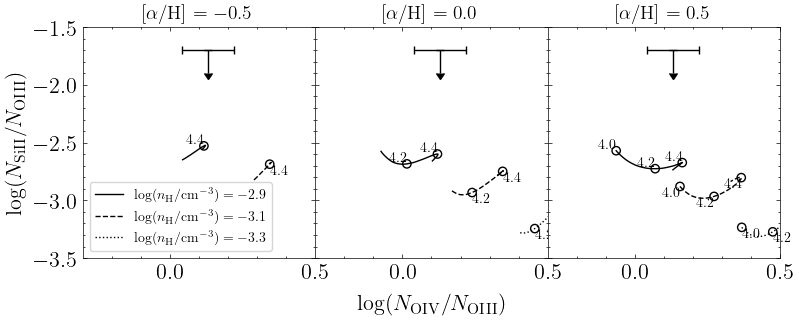

In [61]:
fig, axes = plt.subplots(1,3,figsize=(3*3,3), sharex=True, sharey=True)

# Plot measurements

axes[0].errorbar(0.13, -1.7, xerr=0.09, yerr=0.2, uplims=True, capsize=3)
axes[0].set_title(r'$\mathrm{[\alpha/H]}=-0.5$', fontsize=14)

axes[1].errorbar(0.13, -1.7, xerr=0.09, yerr=0.2, uplims=True, capsize=3)
axes[1].set_title(r'$\mathrm{[\alpha/H]}=0.0$', fontsize=14)

axes[2].errorbar(0.13, -1.7, xerr=0.09, yerr=0.2, uplims=True, capsize=3)
axes[2].set_title(r'$\mathrm{[\alpha/H]}=0.5$', fontsize=14)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'$\log(N_\mathrm{OIV}/N_\mathrm{OIII})$', labelpad=25)
ax_label.set_ylabel(r'$\log(N_\mathrm{SiII}/N_\mathrm{OIII})$', labelpad=40)

plt.subplots_adjust(wspace=0, hspace=0.0)

# Plot tracks
# metals = -0.5

plot_logN_ratio_track(axes[0], 'OIII', 'OIV', 'OIII', 'SiII', logX_dict_TDP_interp,
                      -0.5, -2.9, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -3.5, -1.5,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[0], 'OIII', 'OIV', 'OIII', 'SiII', logX_dict_TDP_interp,
                      -0.5, -3.1, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -3.5, -1.5,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[0], 'OIII', 'OIV', 'OIII', 'SiII', logX_dict_TDP_interp,
                      -0.5, -3.3, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -3.5, -1.5,
                      ':', 'left', 'top')

axes[0].legend(fontsize=10)

# metals = -0.3

plot_logN_ratio_track(axes[1], 'OIII', 'OIV', 'OIII', 'SiII', logX_dict_TDP_interp,
                      0.0, -2.9, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -3.5, -1.5,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[1], 'OIII', 'OIV', 'OIII', 'SiII', logX_dict_TDP_interp,
                      0.0, -3.1, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -3.5, -1.5,
                      '--', 'left', 'top')

plot_logN_ratio_track(axes[1], 'OIII', 'OIV', 'OIII', 'SiII', logX_dict_TDP_interp,
                      0.0, -3.3, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -3.5, -1.5,
                      ':', 'left', 'top')

# metals = 0.0

plot_logN_ratio_track(axes[2], 'OIII', 'OIV', 'OIII', 'SiII', logX_dict_TDP_interp,
                      0.5, -2.9, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -3.5, -1.5,
                      '-', 'right', 'bottom')

plot_logN_ratio_track(axes[2], 'OIII', 'OIV', 'OIII', 'SiII', logX_dict_TDP_interp,
                      0.5, -3.1, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -3.5, -1.5,
                      '--', 'right', 'top')

plot_logN_ratio_track(axes[2], 'OIII', 'OIV', 'OIII', 'SiII', logX_dict_TDP_interp,
                      0.5, -3.3, 
                      4.0, 4.5, .01,
                      4.0, 4.5, .2,
                      -0.3, 0.5, -3.5, -1.5,
                      ':', 'left', 'top')

#plt.savefig(savedir+'z_104_c1H_diagnostic.pdf', dpi=300)
#plt.savefig(savedir+'z_104_c1H_diagnostic.png', dpi=300)

### PIE vs. TDP comparison

In [19]:
logT_arr = np.arange(4.3, 5.0, 0.001)
log_hdens_test = -3
log_metals_test = -0.5
logN_HI_test = 14.9

In [20]:
logN_HeI_TDP = np.array([predict_col_dens_TDP('HeI', log_metals_test, log_hdens_test, logT, logN_HI_test, logX_dict_TDP_interp) for logT in logT_arr])
logN_HeI_PIE = species_logN_interp['He']([logN_HI_test, log_hdens_test, log_metals_test])

logN_OIII_TDP = np.array([predict_col_dens_TDP('OIII', log_metals_test, log_hdens_test, logT, logN_HI_test, logX_dict_TDP_interp) for logT in logT_arr])
logN_OIII_PIE = species_logN_interp['O+2']([logN_HI_test, log_hdens_test, log_metals_test])

logN_OIV_TDP = np.array([predict_col_dens_TDP('OIV', log_metals_test, log_hdens_test, logT, logN_HI_test, logX_dict_TDP_interp) for logT in logT_arr])
logN_OIV_PIE = species_logN_interp['O+3']([logN_HI_test, log_hdens_test, log_metals_test])

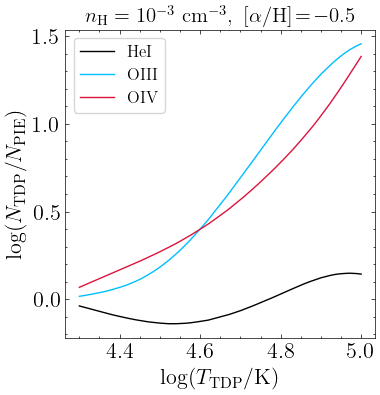

In [21]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.plot(logT_arr, logN_HeI_TDP-logN_HeI_PIE, label='HeI')
ax.plot(logT_arr, logN_OIII_TDP-logN_OIII_PIE, label='OIII')
ax.plot(logT_arr, logN_OIV_TDP-logN_OIV_PIE, label='OIV')

ax.set_xlabel(r'$\log(T_\mathrm{TDP}/\mathrm{K})$')
ax.set_ylabel(r'$\log(N_\mathrm{TDP}/N_\mathrm{PIE})$')

ax.set_title(r'$n_\mathrm{H}=10^{-3} \ \mathrm{cm}^{-3}, \ [\alpha/\mathrm{H}] \!=\! -0.5$', fontsize=15)
ax.legend()

### HeI-HI, OIV-OIII diagnostic

In [22]:
logN_dict = {'HI':'14.9, -0.1, +0.2',
            'HeI':'13.2, -0.1, +0.1',
            #'CII':'<13.8',
            #'CIII':'14.0, -0.5, +0.6',
            #'CIV':'13.64, -0.04, +0.04',
            #'NIV':'13.01, -0.09, +0.09',
            #'NV':'<13.3',
            'OIII':'14.4, -0.1, +0.1',
            'OIV':'14.5, -0.1, +0.1',}
            #'OV':'13.97, -0.03, +0.03',
            #'OVI':'13.7, -0.2, +0.2',
            #'NeV':'<14.0',
            #'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            #'SiII':'<12.6',
            #'SIV':'<14.6',
            #'SVI':'<13.3',
            #'FeII':'<11.6',}

In [24]:
gen_logN_ratio_str(logN_dict['OIV'], logN_dict['OIII'])

'0.10, -0.14, 0.14'

In [25]:
logN_ratio_dict = {'HeI/HI': '-1.70, -0.22, 0.14',
                   'OIV/OIII': '0.10, -0.14, 0.14'
                  }

In [26]:
np.arange(4.3, 5.0, 0.2)

array([4.3, 4.5, 4.7, 4.9])

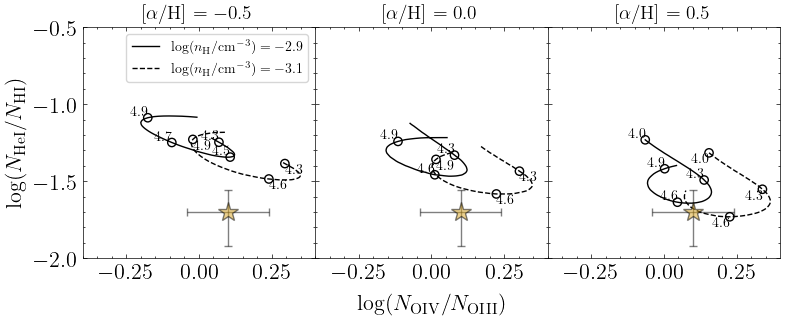

In [27]:
fig, axes = plt.subplots(1,3,figsize=(3*3,3), sharex=True, sharey=True)

ion1 = 'OIII'
ion2 = 'OIV'
ion3 = 'HI'
ion4 = 'HeI'

# Plot measurements

scat_logN_ratio(axes[0], '{}/{}'.format(ion2, ion1), '{}/{}'.format(ion4, ion3), logN_ratio_dict)
axes[0].set_title(r'$\mathrm{[\alpha/H]}=-0.5$', fontsize=14)

scat_logN_ratio(axes[1], '{}/{}'.format(ion2, ion1), '{}/{}'.format(ion4, ion3), logN_ratio_dict)
axes[1].set_title(r'$\mathrm{[\alpha/H]}=0.0$', fontsize=14)

scat_logN_ratio(axes[2], '{}/{}'.format(ion2, ion1), '{}/{}'.format(ion4, ion3), logN_ratio_dict)
axes[2].set_title(r'$\mathrm{[\alpha/H]}=0.5$', fontsize=14)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'$\log(N_\mathrm{OIV}/N_\mathrm{OIII})$', labelpad=25)
ax_label.set_ylabel(r'$\log(N_\mathrm{HeI}/N_\mathrm{HI})$', labelpad=40)

plt.subplots_adjust(wspace=0, hspace=0.0)

# Plot tracks
# Metallicities and densities
m1 = -0.5
m2 = 0.0
m3 = 0.5

d1 = -2.9
d2 = -3.1
d3 = -2.7

# Temperature range
T_plot_min = 4.0
T_plot_max = 5.0
dT_plot = 0.01

T_mark_min = 4.0
T_mark_max = 5.0
dT_mark = 0.3

# Plot range
x_min = -0.4
x_max = 0.4

y_min = -2
y_max = -0.5

# Linestyles 
l1 = '-'
l2 = '--'
l3 = ':'

plot_logN_ratio_track(axes[0], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m1, d1, 
                      T_plot_min, T_plot_max, dT_plot,
                      4.3, 5.0, 0.2,
                      x_min, x_max, y_min, y_max,
                      l1, 'right', 'bottom')


plot_logN_ratio_track(axes[0], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m1, d2, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l2, 'left', 'top')

#plot_logN_ratio_track(axes[0], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
#                      m1, d3, 
#                      T_plot_min, T_plot_max, dT_plot,
#                      T_mark_min, T_mark_max, dT_mark,
#                      x_min, x_max, y_min, y_max,
#                      l3, 'left', 'top')

axes[0].legend(fontsize=10)

# metals = -0.3

plot_logN_ratio_track(axes[1], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m2, d1, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l1, 'right', 'bottom')

plot_logN_ratio_track(axes[1], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m2, d2, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l2, 'left', 'top')

#plot_logN_ratio_track(axes[1], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
#                      m2, d3, 
#                      T_plot_min, T_plot_max, dT_plot,
#                      T_mark_min, T_mark_max, dT_mark,
#                      x_min, x_max, y_min, y_max,
#                      l3, 'left', 'top')

# metals = 0.0

plot_logN_ratio_track(axes[2], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m3, d1, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l1, 'right', 'bottom')

plot_logN_ratio_track(axes[2], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m3, d2, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l2, 'right', 'top')

#plot_logN_ratio_track(axes[2], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
#                      m3, d3, 
#                      T_plot_min, T_plot_max, dT_plot,
#                      T_mark_min, T_mark_max, dT_mark,
#                      x_min, x_max, y_min, y_max,
#                      l3, 'left', 'top')

#plt.savefig(savedir+'z_104_c1H_diagnostic.pdf', dpi=300)
#plt.savefig(savedir+'z_104_c1H_diagnostic.png', dpi=300)

### High-density phase ($\alpha$ and He only)

In [28]:
def log_prior(log_metals, log_hdens, logT):
    
    if log_metals_arr[0]<log_metals<log_metals_arr[-1]:
        if log_hdens_arr[0]<log_hdens<log_hdens_arr[-1]:
            if logT>4.: # Temperature limit based on CIV linewidth
                return 0.
            else:
                return -np.inf
        else:
            return -np.inf
    else:
        return -np.inf

In [29]:
def log_likelihood(log_metals, log_hdens, logT, logN_dict, logX_dict_TDP_interp):
    
    logN_HI_obs = logN_HI_test # Measured N(HI) to generate column densities
    
    ll = 0
    
    for ion in list(logN_dict.keys()):
        
        # Model side: prediction adjusted for elemental abundance
        elem = ion_species_dict[ion].split('+')[0]
        
        y_bar = predict_col_dens_TDP(ion, log_metals, log_hdens, logT, logN_HI_obs, logX_dict_TDP_interp)
            
        # Data side: handle upper limits, lower limits, and measurements separately
        logN_str = logN_dict[ion]
        
        ll += compute_ll(logN_str, y_bar)

    return ll

In [30]:
def log_probability(params, logN_dict, logX_dict_TDP_interp):
    
    log_metals, log_hdens, logT = params
    
    lp = log_prior(log_metals,log_hdens,logT)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp+log_likelihood(log_metals,log_hdens,logT,logN_dict,logX_dict_TDP_interp)

In [34]:
logN_dict = {#'HI':'14.9, -0.1, +0.2',
            #'HeI':'13.2, -0.1, +0.1',
            #'CII':'<13.8',
            #'CIII':'14.0, -0.5, +0.6',
            #'CIV':'13.64, -0.04, +0.04',
            #'NIV':'13.01, -0.09, +0.09',
            #'NV':'<13.3',
            'OIII':'14.4, -0.1, +0.1',
            'OIV':'14.5, -0.1, +0.1',
            'OV': '<14.0', #'13.97, -0.03, +0.03',
            #'OVI':'13.7, -0.2, +0.2',
            #'NeV':'<14.0',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',}
            #'SVI':'<13.3',
            #'FeII':'<11.6',}

In [35]:
log_metals_test = -0.2
log_hdens_test = -3.0
logT_test = 4.3
logN_HI_test = 14.9

logN_test = predict_col_dens_model_TDP(logN_dict,log_metals_test,log_hdens_test,logT_test,logN_HI_test,logX_dict_TDP_interp)

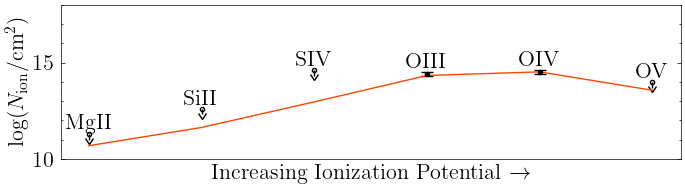

In [36]:
fig, ax = plt.subplots(1, figsize=(8,2))

plot_column_densities_obs(logN_dict, fig, ax)

ax.plot(np.arange(len(logN_dict)), logN_test, color='orangered')

In [37]:
pos = np.array([log_metals_test, log_hdens_test, logT_test]) + 1e-4 * np.random.randn(200, 3)
nwalkers, ndim = pos.shape

In [38]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, logX_dict_TDP_interp)
)

In [39]:
sampler.run_mcmc(pos, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [01:51<00:00,  4.48it/s]


In [40]:
flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_metals', 'log_hdens', 'logT'])
flat_samples.to_csv(savedir+'TDP_hi_dens_c1_alpha_He.csv', index=False)

#flat_samples = pd.read_csv(savedir+'TDP_hi_dens_c1_alpha_He.csv')

OSError: Cannot save file into a non-existent directory: '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z=1.04430803/cloudy_fits'

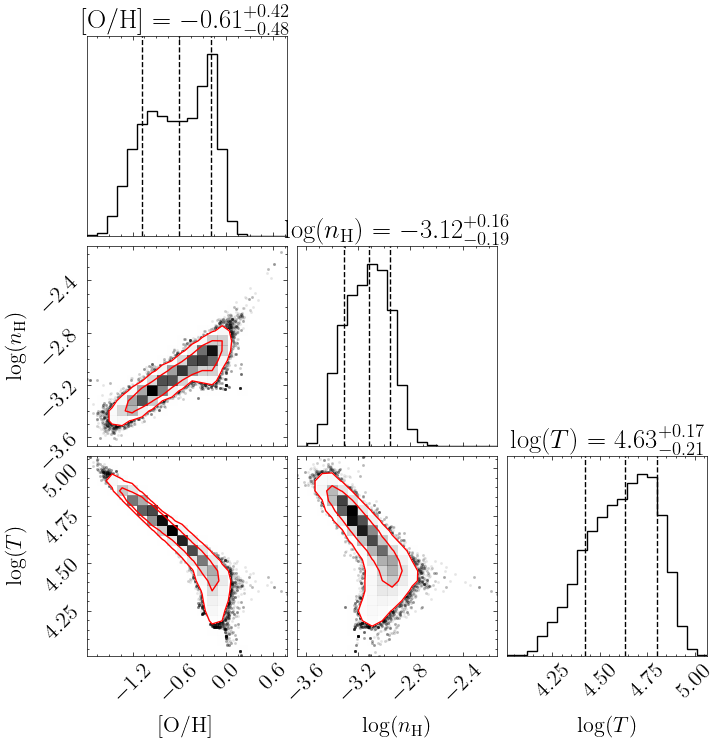

In [86]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\mathrm{[O/H]}$', r'$\log(n_\mathrm{H})$', r'$\log(T)$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Make a plot

In [44]:
logN_dict = {#'HI':'14.8, -0.1, +0.1',
            'HeI':'13.2, -0.1, +0.1',
            'CII':'<13.8',
            'CIII':'14.0, -0.4, +0.5',
            'CIV':'13.64, -0.02, +0.02',
            'NIV':'13.02, -0.09, +0.09',
            #'NV':'<13.3',
            'OIII':'14.33, -0.07, +0.07',
            'OIV':'14.46, -0.06, +0.06',
            'OV':'14.00, -0.02, +0.02',
            'OVI':'13.8, -0.1, +0.1',
            #'NeV':'<14.0',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',}
            #'SVI':'<13.3',
            #'FeII':'<11.6'}

In [45]:
b_dict = {'HI':'19, -1, +1',
          'HeI': '10, -1, +1',
          'CIII':'6.7, -0.2, +0.2',
          'CIV':'6.7, -0.2, +0.2',
          'NIV':'6.7, -0.2, +0.2',
          'OIII':'6.7, -0.2, +0.2',
          'OIV':'6.7, -0.2, +0.2',
          'OV':'23, -1, +1',
          'OVI':'23, -1, +1'}

In [46]:
logN_species_best = predict_col_dens_model_TDP(logN_dict,
                                               np.median(flat_samples['log_metals']),
                                               np.median(flat_samples['log_hdens']),
                                               np.median(flat_samples['logT']),
                                               logN_HI_test,
                                               logX_dict_TDP_interp,
                                               0.,
                                               0.)

In [47]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [48]:
logN_res_up = {k:'<0.8' for k in list(logN_res_dict.keys())}

#logN_res_up['SiIII'] = '<0.4'
#logN_res_up['SiIV'] = '<0.4'
#logN_res_up['OIII'] = '<0.4'
#logN_res_up['NIV'] = '<0.4'

In [49]:
logN_species_grid = np.zeros((len(logN_dict), len(flat_samples)))

ctr = 0

for i in range(len(ion_species_dict)):
    
    ion = list(ion_species_dict.keys())[i]
    
    if ion in list(logN_dict.keys()):
        s = ion_species_dict[ion] # Species, for PIE
        elem = ion_species_dict[ion].split('+')[0] # Element, for non-solar abundances
        
        logN_species_grid[ctr,:] = predict_col_dens_TDP(ion, 
                                      flat_samples['log_metals'],
                                      flat_samples['log_hdens'],
                                      flat_samples['logT'],
                                      logN_HI_test,
                                      logX_dict_TDP_interp)
         
        ctr += 1

In [50]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

logT_lo = np.percentile(flat_samples['logT'], 100*(1-cdf_1sig))
logT_hi = np.percentile(flat_samples['logT'], 100*cdf_1sig)


for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    logT = flat_samples['logT'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and logT_lo<logT<logT_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

In [51]:
import matplotlib.lines as mlines

In [52]:
z_sys = 1.04430803

(3.0, 27.0)

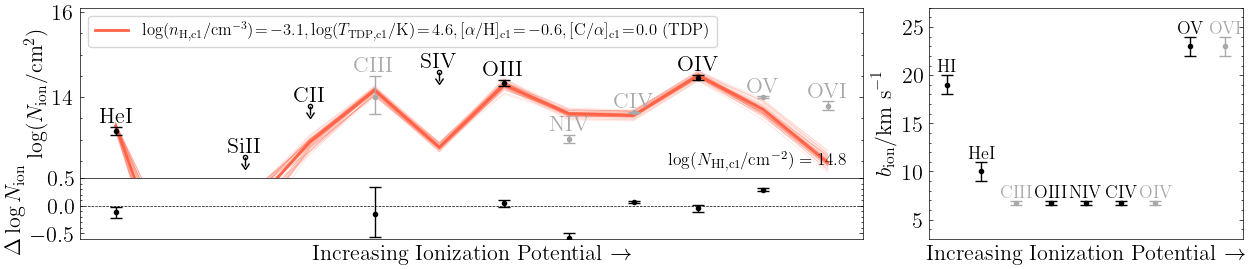

In [53]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'],
                          gray_out = ['OV', 'OVI', 'CIV', 'NIV', 'CIII'], dy=.15)

axd['upper left'].set_ylim(12.1,16.1)

axd['upper left'].text(len(logN_dict)-0.7, 12.4, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.8$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H,c1}/\mathrm{cm}^{-3}) \!=\! -3.1, \log(T_\mathrm{TDP,c1}/\mathrm{K})\!=\!4.6, \mathrm{[\alpha/H]_{c1}} \!=\! -0.6, \mathrm{[C/\alpha]_{c1}}\!=\!0.0$ (TDP)'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'],gray_out = ['OVI','NeV', 'NeVI'],label_ions=False,dy=.1)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'],gray_out = ['OVI','NeV', 'NeVI'],label_ions=False,dy=.1)

axd['lower left'].set_ylim(-0.6,.5)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=13, gray_out = ['CIII', 'OIV', 'OVI'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(3,27)
#ax.set_title('Two-phase decomposition for a CIV absorber', fontsize=18)

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_TDP.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)
#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_TDP.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Cloud size posterior

In [54]:
logl = get_logl_TDP(flat_samples['log_metals'], flat_samples['log_hdens'], flat_samples['logT'], logN_HI_test, logX_dict_TDP_interp)

(array([6.2100e+02, 5.0112e+04, 2.9101e+04, 3.2000e+01, 5.8000e+01,
        3.8000e+01, 1.3000e+01, 6.0000e+00, 0.0000e+00, 1.9000e+01]),
 array([-1.85568414, -0.64193557,  0.57181299,  1.78556156,  2.99931013,
         4.21305869,  5.42680726,  6.64055582,  7.85430439,  9.06805296,
        10.28180152]),
 <BarContainer object of 10 artists>)

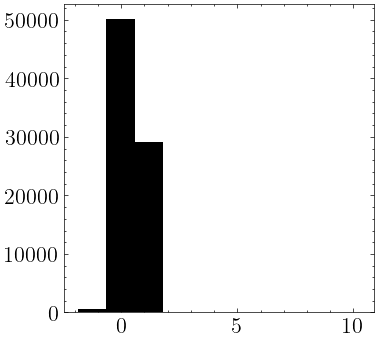

In [55]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logl)

In [56]:
get_quantiles(logl)

0.3 -0.56 0.68


### High-density phase ($\alpha$ and carbon, assume solar [C/O])

In [91]:
def log_prior(log_metals, log_hdens, logT):
    
    if log_metals_arr[0]<log_metals<log_metals_arr[-1]:
        if log_hdens_arr[0]<log_hdens<log_hdens_arr[-1]:
            if logT>4.: # Temperature limit based on CIV linewidth
                return 0.
            else:
                return -np.inf
        else:
            return -np.inf
    else:
        return -np.inf

In [92]:
def log_likelihood(log_metals, log_hdens, logT, logN_dict, logX_dict_TDP_interp):
    
    logN_HI_obs = logN_HI_test # Measured N(HI) to generate column densities
    
    ll = 0
    
    for ion in list(logN_dict.keys()):
        
        # Model side: prediction adjusted for elemental abundance
        elem = ion_species_dict[ion].split('+')[0]
        
        y_bar = predict_col_dens_TDP(ion, log_metals, log_hdens, logT, logN_HI_obs, logX_dict_TDP_interp)
            
        # Data side: handle upper limits, lower limits, and measurements separately
        logN_str = logN_dict[ion]
        
        ll += compute_ll(logN_str, y_bar)

    return ll

In [93]:
def log_probability(params, logN_dict, logX_dict_TDP_interp):
    
    log_metals, log_hdens, logT = params
    
    lp = log_prior(log_metals,log_hdens,logT)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp+log_likelihood(log_metals,log_hdens,logT,logN_dict,logX_dict_TDP_interp)

In [119]:
logN_dict = {#'HI':'14.8, -0.1, +0.1',
            #'HeI':'13.2, -0.1, +0.1',
            #'CII':'<13.8',
            'CIII':'14.0, -0.4, +0.5',
            'CIV':'13.64, -0.02, +0.02',
            #'NIV':'13.02, -0.09, +0.09',
            #'NV':'<13.3',
            'OIII':'14.33, -0.07, +0.07',
            'OIV':'14.46, -0.06, +0.06',
            'OV': '<14.0', #'14.00, -0.02, +0.02',
            #'OVI':'13.8, -0.1, +0.1',
            #'NeV':'<14.0',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',}
            #'SVI':'<13.3',
            #'FeII':'<11.6'}

In [120]:
log_metals_test = -0.2
log_hdens_test = -3.0
logT_test = 4.4
logN_HI_test = 14.8

logN_test = predict_col_dens_model_TDP(logN_dict,log_metals_test,log_hdens_test,logT_test,logN_HI_test,logX_dict_TDP_interp)

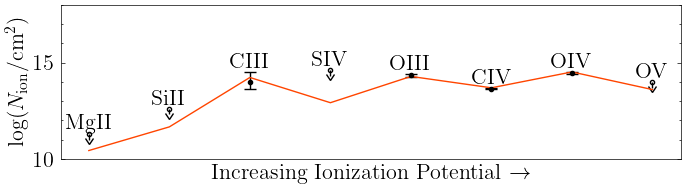

In [121]:
fig, ax = plt.subplots(1, figsize=(8,2))

plot_column_densities_obs(logN_dict, fig, ax)

ax.plot(np.arange(len(logN_dict)), logN_test, color='orangered')

In [122]:
pos = np.array([log_metals_test, log_hdens_test, logT_test]) + 1e-4 * np.random.randn(200, 3)
nwalkers, ndim = pos.shape

In [123]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, logX_dict_TDP_interp)
)

In [124]:
sampler.run_mcmc(pos, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [02:37<00:00,  3.18it/s]


In [125]:
flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_metals', 'log_hdens', 'logT'])
flat_samples.to_csv(savedir+'TDP_hi_dens_c1_alpha_C.csv', index=False)

#flat_samples = pd.read_csv(savedir+'TDP_hi_dens_c1_alpha_C.csv')

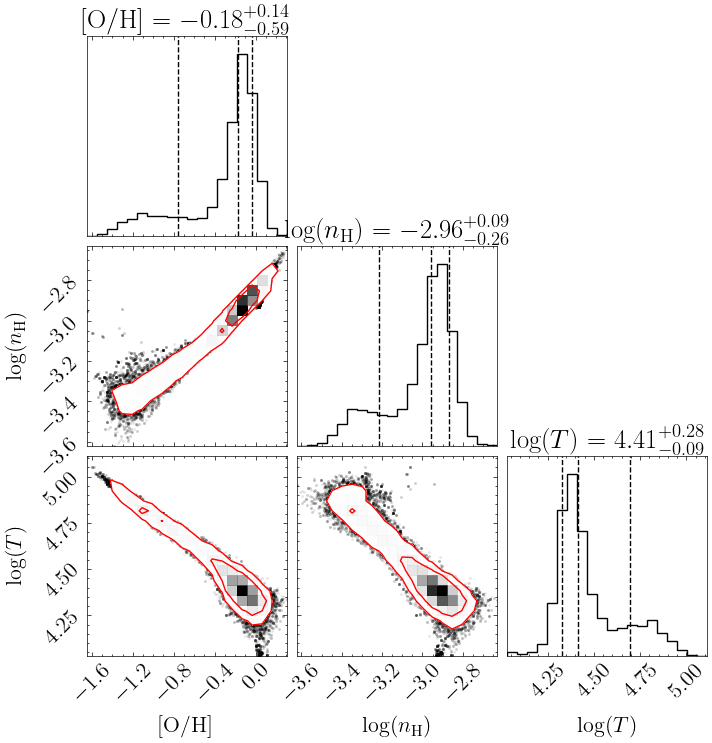

In [126]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\mathrm{[O/H]}$', r'$\log(n_\mathrm{H})$', r'$\log(T)$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Make a plot

In [127]:
logN_dict = {#'HI':'14.8, -0.1, +0.1',
            'HeI':'13.2, -0.1, +0.1',
            'CII':'<13.8',
            'CIII':'14.0, -0.4, +0.5',
            'CIV':'13.64, -0.02, +0.02',
            'NIV':'13.02, -0.09, +0.09',
            #'NV':'<13.3',
            'OIII':'14.33, -0.07, +0.07',
            'OIV':'14.46, -0.06, +0.06',
            'OV':'14.00, -0.02, +0.02',
            'OVI':'13.8, -0.1, +0.1',
            #'NeV':'<14.0',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',}
            #'SVI':'<13.3',
            #'FeII':'<11.6'}

In [128]:
b_dict = {'HI':'19, -1, +1',
          'HeI': '10, -1, +1',
          'CIII':'6.7, -0.2, +0.2',
          'CIV':'6.7, -0.2, +0.2',
          'NIV':'6.7, -0.2, +0.2',
          'OIII':'6.7, -0.2, +0.2',
          'OIV':'6.7, -0.2, +0.2',
          'OV':'23, -1, +1',
          'OVI':'23, -1, +1'}

In [129]:
logN_species_best = predict_col_dens_model_TDP(logN_dict,
                                               np.median(flat_samples['log_metals']),
                                               np.median(flat_samples['log_hdens']),
                                               np.median(flat_samples['logT']),
                                               logN_HI_test,
                                               logX_dict_TDP_interp,
                                               0.,
                                               0.)

In [130]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [131]:
logN_res_up = {k:'<0.8' for k in list(logN_res_dict.keys())}

#logN_res_up['SiIII'] = '<0.4'
#logN_res_up['SiIV'] = '<0.4'
#logN_res_up['OIII'] = '<0.4'
#logN_res_up['NIV'] = '<0.4'

In [132]:
logN_species_grid = np.zeros((len(logN_dict), len(flat_samples)))

ctr = 0

for i in range(len(ion_species_dict)):
    
    ion = list(ion_species_dict.keys())[i]
    
    if ion in list(logN_dict.keys()):
        s = ion_species_dict[ion] # Species, for PIE
        elem = ion_species_dict[ion].split('+')[0] # Element, for non-solar abundances
        
        logN_species_grid[ctr,:] = predict_col_dens_TDP(ion, 
                                      flat_samples['log_metals'],
                                      flat_samples['log_hdens'],
                                      flat_samples['logT'],
                                      logN_HI_test,
                                      logX_dict_TDP_interp)
         
        ctr += 1

In [133]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

logT_lo = np.percentile(flat_samples['logT'], 100*(1-cdf_1sig))
logT_hi = np.percentile(flat_samples['logT'], 100*cdf_1sig)


for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    logT = flat_samples['logT'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and logT_lo<logT<logT_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

In [134]:
import matplotlib.lines as mlines

In [135]:
z_sys = 1.04430803

(3.0, 27.0)

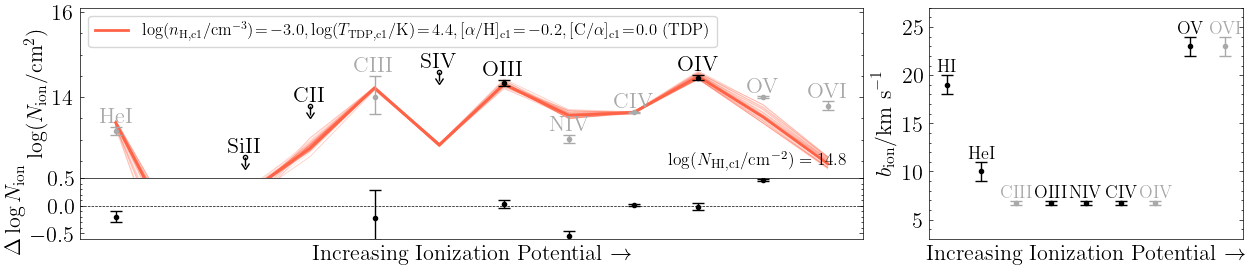

In [137]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'],
                          gray_out = ['HeI','OV', 'OVI', 'CIV', 'NIV', 'CIII'], dy=.15)

axd['upper left'].set_ylim(12.1,16.1)

axd['upper left'].text(len(logN_dict)-0.7, 12.4, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.8$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H,c1}/\mathrm{cm}^{-3}) \!=\! -3.0, \log(T_\mathrm{TDP,c1}/\mathrm{K})\!=\!4.4, \mathrm{[\alpha/H]_{c1}} \!=\! -0.2, \mathrm{[C/\alpha]_{c1}}\!=\!0.0$ (TDP)'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'],gray_out = ['OVI','NeV', 'NeVI'],label_ions=False,dy=.1)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'],gray_out = ['OVI','NeV', 'NeVI'],label_ions=False,dy=.1)

axd['lower left'].set_ylim(-0.6,.5)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=13, gray_out = ['CIII', 'OIV', 'OVI'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(3,27)
#ax.set_title('Two-phase decomposition for a CIV absorber', fontsize=18)

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_TDP.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)
#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_TDP.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Cloud size posterior

In [138]:
logl = get_logl_TDP(flat_samples['log_metals'], flat_samples['log_hdens'], flat_samples['logT'], logN_HI_test, logX_dict_TDP_interp)

(array([ 1523., 20972., 27784.,  9441.,  4211.,  3950.,  4126.,  4745.,
         2966.,   282.]),
 array([-1.01584633, -0.73701225, -0.45817817, -0.17934409,  0.09948999,
         0.37832407,  0.65715816,  0.93599224,  1.21482632,  1.4936604 ,
         1.77249448]),
 <BarContainer object of 10 artists>)

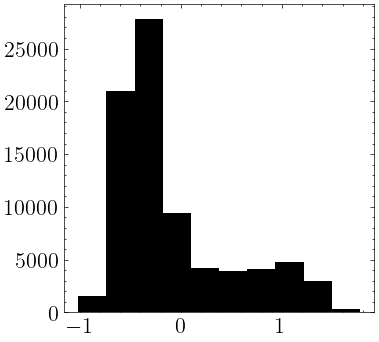

In [139]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logl)

In [140]:
get_quantiles(logl)

-0.31 -0.24 0.93


### High-density phase (vary both temperature and [C/O])

In [45]:
def log_prior(log_metals, log_hdens, logT, C_O, N_O):
    
    if log_metals_arr[0]<log_metals<log_metals_arr[-1] and -3<log_metals+C_O<1 and -3<log_metals+N_O<1: #[C/H]
        if log_hdens_arr[0]<log_hdens<log_hdens_arr[-1]:
            if logT>4.0: #4.0<logT<4.5:  # Temperature limit based on CIV linewidth
                return 0.
            else:
                return -np.inf
        else:
            return -np.inf
    else:
        return -np.inf

In [46]:
def log_likelihood(log_metals, log_hdens, logT, C_O, N_O, logN_dict, logX_dict_TDP_interp):
    
    logN_HI_obs = logN_HI_test # Measured N(HI) to generate column densities
    
    ll = 0
    
    for ion in list(logN_dict.keys()):
        
        # Model side: prediction adjusted for elemental abundance
        elem = ion_species_dict[ion].split('+')[0]
        
        y_bar = predict_col_dens_TDP(ion, log_metals, log_hdens, logT, logN_HI_obs, logX_dict_TDP_interp)
        if elem == 'C':
            y_bar += C_O 
        if elem == 'N':
            y_bar += N_O
            
        # Data side: handle upper limits, lower limits, and measurements separately
        logN_str = logN_dict[ion]
        
        ll += compute_ll(logN_str, y_bar)

    return ll

In [47]:
def log_probability(params, logN_dict, logX_dict_TDP_interp):
    
    log_metals, log_hdens, logT, C_O, N_O = params
    
    lp = log_prior(log_metals,log_hdens,logT,C_O,N_O)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp+log_likelihood(log_metals,log_hdens,logT,C_O,N_O,logN_dict,logX_dict_TDP_interp)

In [48]:
logN_dict = {#'HI':'14.9, -0.1, +0.2',
            #'HeI':'13.2, -0.1, +0.1',
            'CII':'<13.8',
            'CIII':'14.0, -0.5, +0.6',
            'CIV':'13.64, -0.04, +0.04',
            'NIV':'13.01, -0.09, +0.09',
            #'NV':'<13.3',
            'OIII':'14.4, -0.1, +0.1',
            'OIV':'14.5, -0.1, +0.1',
            'OV': '<14.0', #'13.97, -0.03, +0.03',
            #'OVI':'13.7, -0.2, +0.2',
            #'NeV':'<14.0',
            'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',}
            #'SVI':'<13.3',
            #'FeII':'<11.6',}

In [51]:
log_metals_test = 0.0
log_hdens_test = -2.9
logT_test = 4.3
logN_HI_test = 14.9
C_O_test = -0.1
N_O_test = -0.8

logN_test = predict_col_dens_model_TDP(logN_dict,log_metals_test,log_hdens_test,logT_test,logN_HI_test,logX_dict_TDP_interp, C_O_test, N_O_test)

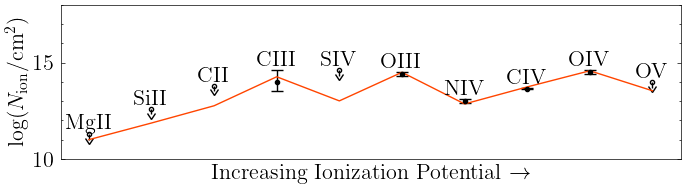

In [52]:
fig, ax = plt.subplots(1, figsize=(8,2))

plot_column_densities_obs(logN_dict, fig, ax)

ax.plot(np.arange(len(logN_dict)), logN_test, color='orangered')

In [53]:
pos = np.array([log_metals_test, log_hdens_test, logT_test, C_O_test, N_O_test]) + 1e-4 * np.random.randn(200, 5)
nwalkers, ndim = pos.shape

In [54]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, logX_dict_TDP_interp)
)

In [55]:
sampler.run_mcmc(pos, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [03:02<00:00,  2.73it/s]


In [56]:
flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_metals', 'log_hdens', 'logT', 'C_O', 'N_O'])
flat_samples.to_csv(savedir+'TDP_hi_dens_c1_all.csv', index=False)

#flat_samples = pd.read_csv(savedir+'TDP_hi_dens_c1_all.csv')

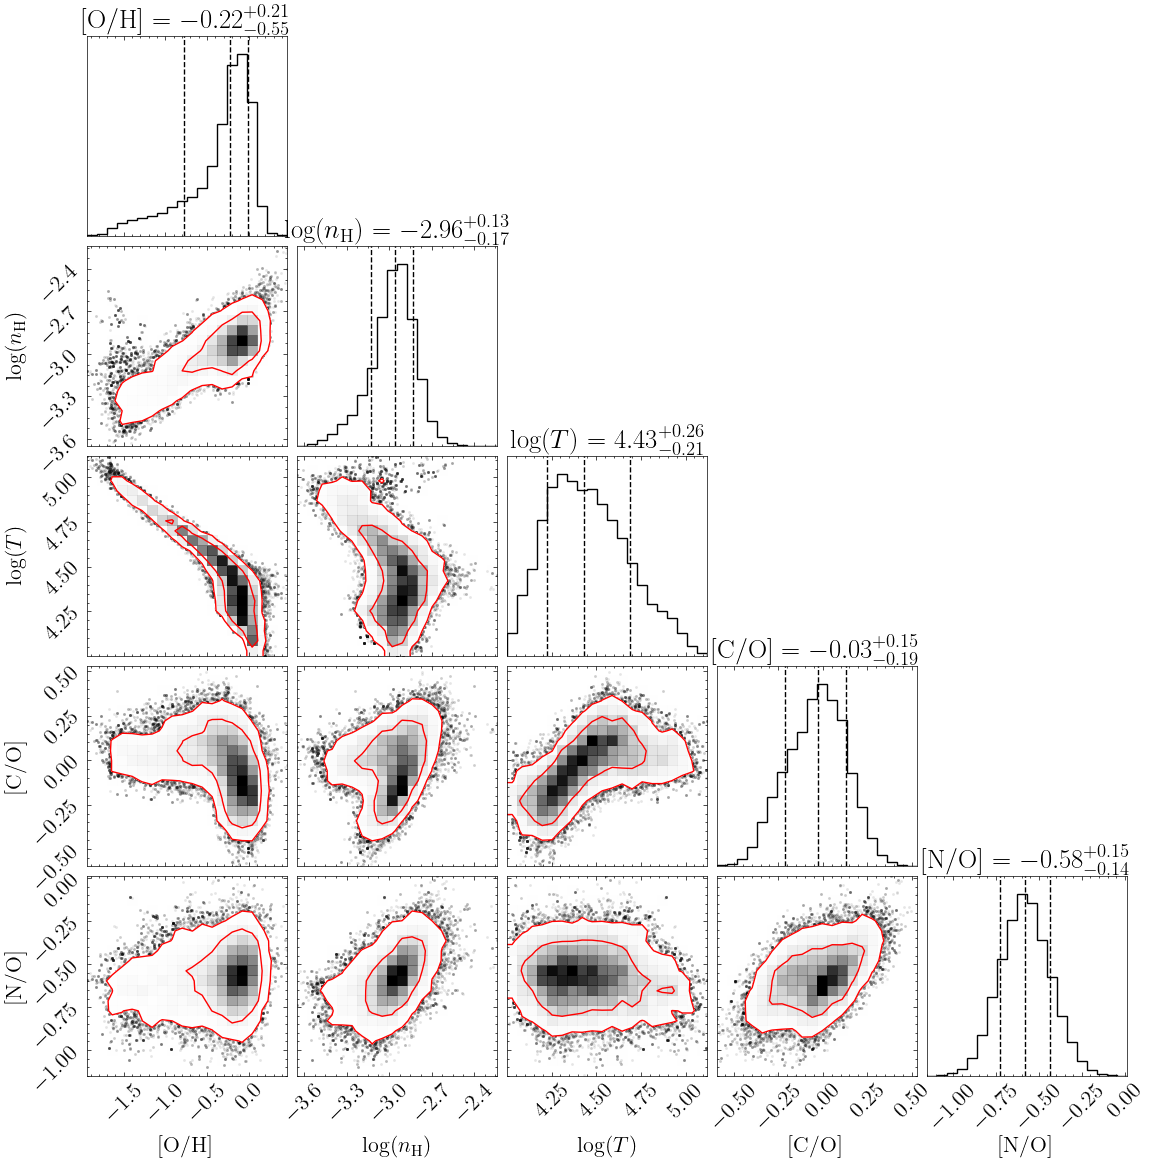

In [57]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\mathrm{[O/H]}$', r'$\log(n_\mathrm{H})$', r'$\log(T)$', r'$\mathrm{[C/O]}$',r'$\mathrm{[N/O]}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Text(0, 0.5, 'Counts')

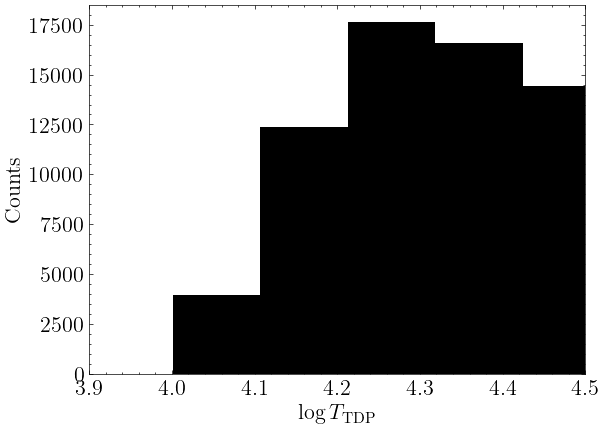

In [358]:
plt.hist(flat_samples['logT'])
plt.xlim(3.9,4.5)

plt.xlabel(r'$\log T_\mathrm{TDP}$')
plt.ylabel('Counts')

In [321]:
np.median(flat_samples['C_O']), np.median(flat_samples['C_O'])-np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))

(-0.02500535137642045, 0.16433382576178457)

In [322]:
np.percentile(flat_samples['logT'], 100*(1-cdf_3sig)), np.percentile(flat_samples['logT'], 100*cdf_3sig)

(4.024863178621748, 4.941314484348037)

In [323]:
np.percentile(flat_samples['N_O'], 100*cdf_3sig)

-0.19571109576048373

Make a plot

In [344]:
logN_dict = {#'HI':'14.8, -0.1, +0.1',
            'HeI':'13.2, -0.1, +0.1',
            'CII':'<13.8',
            'CIII':'14.0, -0.4, +0.5',
            'CIV':'13.64, -0.02, +0.02',
            'NIV':'13.02, -0.09, +0.09',
            #'NV':'<13.3',
            'OIII':'14.33, -0.07, +0.07',
            'OIV':'14.46, -0.06, +0.06',
            'OV': '14.00, -0.02, +0.02',
            'OVI':'13.8, -0.1, +0.1',
            #'NeV':'<14.0',
            #'MgII':'<11.3',
            #'MgX':'<13.6',
            #'AlII':'<11.1',
            #'AlIII':'<11.5',
            'SiII':'<12.6',
            'SIV':'<14.6',}
            #'SVI':'<13.3',
            #'FeII':'<11.6'}

In [345]:
b_dict = {'HI':'19, -1, +1',
          'HeI': '10, -1, +1',
          'CIII':'6.7, -0.2, +0.2',
          'CIV':'6.7, -0.2, +0.2',
          'NIV':'6.7, -0.2, +0.2',
          'OIII':'6.7, -0.2, +0.2',
          'OIV':'6.7, -0.2, +0.2',
          'OV':'23, -1, +1',
          'OVI':'23, -1, +1'}

In [346]:
logN_species_best = predict_col_dens_model_TDP(logN_dict,
                                               np.median(flat_samples['log_metals']),
                                               np.median(flat_samples['log_hdens']),
                                               np.median(flat_samples['logT']),
                                               logN_HI_test,
                                               logX_dict_TDP_interp,
                                               np.median(flat_samples['C_O']),
                                               np.median(flat_samples['N_O']))

In [347]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [348]:
logN_res_up = {k:'<0.8' for k in list(logN_res_dict.keys())}

#logN_res_up['SiIII'] = '<0.4'
#logN_res_up['SiIV'] = '<0.4'
#logN_res_up['OIII'] = '<0.4'
#logN_res_up['NIV'] = '<0.4'

In [349]:
logN_species_grid = np.zeros((len(logN_dict), len(flat_samples)))

ctr = 0

for i in range(len(ion_species_dict)):
    
    ion = list(ion_species_dict.keys())[i]
    
    if ion in list(logN_dict.keys()):
        s = ion_species_dict[ion] # Species, for PIE
        elem = ion_species_dict[ion].split('+')[0] # Element, for non-solar abundances
        
        logN_species_grid[ctr,:] = predict_col_dens_TDP(ion, 
                                      flat_samples['log_metals'],
                                      flat_samples['log_hdens'],
                                      flat_samples['logT'],
                                      logN_HI_test,
                                      logX_dict_TDP_interp)
        
        if elem == 'C':
            logN_species_grid[ctr,:] += flat_samples['C_O']
            
        if elem == 'N':
            logN_species_grid[ctr,:] += flat_samples['N_O']
            
        ctr += 1

In [350]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

C_O_lo = np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))
C_O_hi = np.percentile(flat_samples['C_O'], 100*cdf_1sig)

N_O_lo = np.percentile(flat_samples['N_O'], 100*(1-cdf_1sig))
N_O_hi = np.percentile(flat_samples['N_O'], 100*cdf_1sig)

for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    C_O = flat_samples['C_O'][i]
    N_O = flat_samples['N_O'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and C_O_lo<C_O<C_O_hi and N_O_lo<N_O<N_O_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

In [351]:
import matplotlib.lines as mlines

In [352]:
z_sys = 1.04430803

(3.0, 27.0)

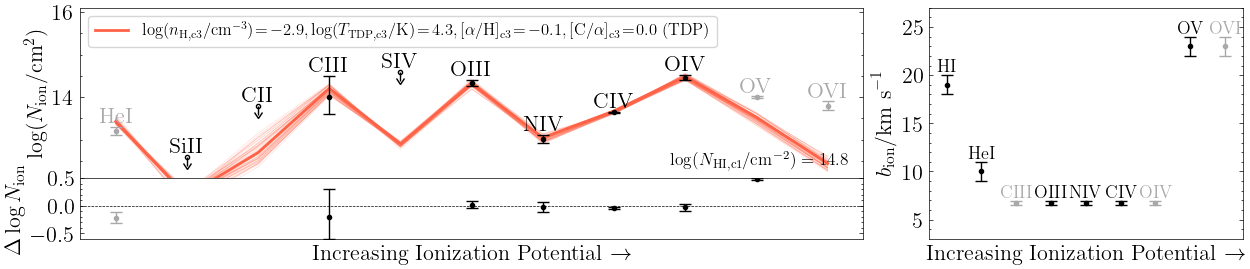

In [353]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'],
                          gray_out = ['HeI','OV','OVI',
                                     'NeV', 'NeVI'], dy=.15)

axd['upper left'].set_ylim(12.1,16.1)

axd['upper left'].text(len(logN_dict)-0.7, 12.4, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.8$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H,c3}/\mathrm{cm}^{-3}) \!=\! -2.9, \log(T_\mathrm{TDP,c3}/\mathrm{K})\!=\!4.3, \mathrm{[\alpha/H]_{c3}} \!=\! -0.1, \mathrm{[C/\alpha]_{c3}}\!=\!0.0$ (TDP)'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'],gray_out = ['HeI','OVI','NeV', 'NeVI'],label_ions=False,dy=.1)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'],gray_out = ['HeI','OVI','NeV', 'NeVI'],label_ions=False,dy=.1)

axd['lower left'].set_ylim(-0.6,.5)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=13, gray_out = ['CIII', 'OIV', 'OVI'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(3,27)
#ax.set_title('Two-phase decomposition for a CIV absorber', fontsize=18)

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_TDP.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)
#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_TDP.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Cloud size posterior

In [268]:
logl = get_logl_TDP(flat_samples['log_metals'], flat_samples['log_hdens'], flat_samples['logT'], logN_HI_test, logX_dict_TDP_interp)

(array([2.9732e+04, 4.3889e+04, 4.1660e+03, 1.6530e+03, 2.7100e+02,
        1.4500e+02, 8.3000e+01, 2.0000e+01, 1.2000e+01, 2.9000e+01]),
 array([-1.05230206, -0.41900106,  0.21429993,  0.84760093,  1.48090192,
         2.11420292,  2.74750392,  3.38080491,  4.01410591,  4.6474069 ,
         5.2807079 ]),
 <BarContainer object of 10 artists>)

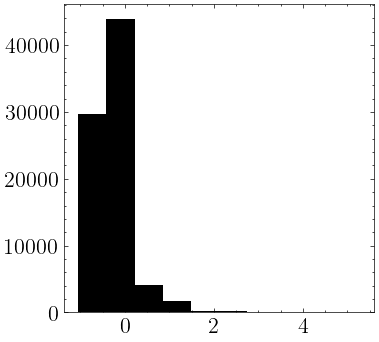

In [269]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logl)

In [270]:
get_quantiles(logl)

-0.35 -0.19 0.3
